# Libraries

In [1]:
import requests
import pandas as pd
import json
from typing import Optional, Dict, Any, List
from missingno import matrix
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
import seaborn as sns
from fastai.tabular.core import add_datepart
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, AffinityPropagation, SpectralClustering
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
import gower
import warnings
warnings.filterwarnings('ignore')

## No column display limit

In [2]:
pd.set_option('display.max_columns', None)

# Data extraction

## API setup

In [3]:
class LongBeachAnimalShelterAPI:
    """
    A Python client for extracting data from the Long Beach Animal Shelter API
    using the Opendatasoft Explore API v2.1
    """
    
    def __init__(self):
        self.base_url = "https://longbeach.opendatasoft.com/api/explore/v2.1"
        self.dataset_id = "animal-shelter-intakes-and-outcomes"
        
    def get_all_records(self, 
                       select: Optional[str] = None,
                       where: Optional[str] = None,
                       order_by: Optional[str] = None) -> pd.DataFrame:
        """
        Extract all records from the animal shelter dataset without limits.
        
        Args:
            select: Fields to select (default: all fields)
            where: Filter conditions using ODSQL syntax
            order_by: Order by clause
            
        Returns:
            pandas.DataFrame with all records
        """
        
        all_records = []
        offset = 0
        limit = 100  # Maximum allowed per request
        
        while True:
            # Build API request
            url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/records"
            
            params = {
                'limit': limit,
                'offset': offset
            }
            
            # Add optional parameters
            if select:
                params['select'] = select
            if where:
                params['where'] = where
            if order_by:
                params['order_by'] = order_by
                
            try:
                response = requests.get(url, params=params)
                response.raise_for_status()
                
                data = response.json()
                
                # Extract records from response
                records = data.get('results', [])
                
                if not records:
                    break
                    
                all_records.extend(records)
                
                # Check if we've retrieved all records
                total_count = data.get('total_count', 0)
                if len(all_records) >= total_count:
                    break
                    
                # Move to next batch
                offset += limit
                
                print(f"Retrieved {len(all_records)} of {total_count} records...")
                
            except requests.RequestException as e:
                print(f"Error fetching data: {e}")
                break
                
        # Convert to DataFrame
        df = pd.DataFrame(all_records)
        print(f"Successfully retrieved {len(df)} total records")
        
        return df
    
    def get_dataset_info(self) -> Dict[str, Any]:
        """
        Get metadata about the dataset including field information.
        
        Returns:
            Dictionary with dataset metadata
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            return response.json()
            
        except requests.RequestException as e:
            print(f"Error fetching dataset info: {e}")
            return {}
    
    def export_to_csv(self, 
                     filename: str = "animal_shelter_data.csv",
                     select: Optional[str] = None,
                     where: Optional[str] = None) -> bool:
        """
        Export data directly to CSV using the API's export endpoint.
        
        Args:
            filename: Output CSV filename
            select: Fields to select
            where: Filter conditions
            
        Returns:
            True if successful, False otherwise
        """
        url = f"{self.base_url}/catalog/datasets/{self.dataset_id}/exports/csv"
        
        params = {'limit': -1}  # -1 means no limit for exports
        
        if select:
            params['select'] = select
        if where:
            params['where'] = where
            
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            
            with open(filename, 'wb') as f:
                f.write(response.content)
                
            print(f"Data exported to {filename}")
            return True
            
        except requests.RequestException as e:
            print(f"Error exporting data: {e}")
            return False

## Run

In [4]:
if __name__ == "__main__":
    
    # Initialize the API client
    api = LongBeachAnimalShelterAPI()
    
    # Example 1: Get all records
    print("Fetching all animal shelter records...")
    df = api.get_all_records()
    print(f"Retrieved {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    
    
    # Example 5: Export directly to CSV
    print("\nExporting all data to CSV...")
    api.export_to_csv("longbeach_animal_shelter_complete.csv")
    
    
    # Display sample data
    if not df.empty:
        print("\nSample data:")
        print(df.head())

Fetching all animal shelter records...
Retrieved 100 of 32266 records...
Retrieved 200 of 32266 records...
Retrieved 300 of 32266 records...
Retrieved 400 of 32266 records...
Retrieved 500 of 32266 records...
Retrieved 600 of 32266 records...
Retrieved 700 of 32266 records...
Retrieved 800 of 32266 records...
Retrieved 900 of 32266 records...
Retrieved 1000 of 32266 records...
Retrieved 1100 of 32266 records...
Retrieved 1200 of 32266 records...
Retrieved 1300 of 32266 records...
Retrieved 1400 of 32266 records...
Retrieved 1500 of 32266 records...
Retrieved 1600 of 32266 records...
Retrieved 1700 of 32266 records...
Retrieved 1800 of 32266 records...
Retrieved 1900 of 32266 records...
Retrieved 2000 of 32266 records...
Retrieved 2100 of 32266 records...
Retrieved 2200 of 32266 records...
Retrieved 2300 of 32266 records...
Retrieved 2400 of 32266 records...
Retrieved 2500 of 32266 records...
Retrieved 2600 of 32266 records...
Retrieved 2700 of 32266 records...
Retrieved 2800 of 32266 r

In [5]:
df = pd.read_csv("longbeach_animal_shelter_complete.csv", sep=None, engine='python')

## Data info

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32266 entries, 0 to 32265
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ﻿animal_id         32266 non-null  object 
 1   animal_name        19120 non-null  object 
 2   animal_type        32266 non-null  object 
 3   primary_color      32266 non-null  object 
 4   secondary_color    15307 non-null  object 
 5   sex                32266 non-null  object 
 6   dob                28124 non-null  object 
 7   intake_date        32266 non-null  object 
 8   intake_cond        32266 non-null  object 
 9   intake_type        32266 non-null  object 
 10  intake_subtype     31831 non-null  object 
 11  reason             2127 non-null   object 
 12  outcome_date       32017 non-null  object 
 13  crossing           32266 non-null  object 
 14  jurisdiction       32266 non-null  object 
 15  outcome_type       32009 non-null  object 
 16  outcome_subtype    285

## Data preview

In [7]:
df.head()

,﻿animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
0,A651730,*ARCHIE,CAT,WHITE,GRAY,Neutered,2019-11-20,2020-11-20,NORMAL,STRAY,OTC,NaN,2020-12-05,"1500 BLK LOCUST AVE, LONG BEACH CA 90813",LONG BEACH,ADOPTION,WEB,33.785438,-118.190925,Alive on Intake,False,1,"33.7854384, -118.1909253",15.0,0
1,A614543,NaN,CAT,LYNX PT,NaN,Unknown,2018-08-12,2018-09-12,UNDER AGE/WEIGHT,STRAY,FIELD,NaN,2018-09-16,"1500 BLK LOCUST AVE, LONG BEACH, CA 90813",LONG BEACH,EUTHANASIA,UNDRAGE/WT,33.785438,-118.190925,Alive on Intake,True,0,"33.7854384, -118.1909253",4.0,0
2,A664975,GARRETT,DOG,BLACK,NaN,Neutered,2021-02-06,2025-04-07,NORMAL,STRAY,FIELD,NaN,2025-04-20,"1500 BLK MARTIN LUTHER KING JR AVE, LONG BEACH, CA 90813",LONG BEACH,TRANSFER,SPCALA,33.785923,-118.180381,Alive on Intake,False,1,"33.7859229, -118.1803806",13.0,0
3,A632371,GARFIELD,CAT,ORG TABBY,NaN,Male,2016-08-22,2019-08-22,NORMAL,STRAY,FIELD,NaN,2019-08-24,"1500 BLK N STANTON PL, LONG BEACH, CA 90804",LONG BEACH,RETURN TO OWNER,WALKIN,33.786234,-118.164772,Alive on Intake,False,1,"33.786234, -118.1647715",2.0,0
4,A617427,NaN,CAT,ORANGE,WHITE,Male,2011-11-10,2018-11-10,INJURED SEVERE,STRAY,FIELD,NaN,2018-11-10,"1500 BLK N STANTON PL, LONG BEACH, CA 90804",LONG BEACH,EUTHANASIA,ILL SEVERE,33.786234,-118.164772,Alive on Intake,True,0,"33.786234, -118.1647715",0.0,0


## Data format change for pandas

In [8]:
df.columns = df.columns.str.strip().str.replace('\ufeff', '') # Removing whitespaces in column names

## Duplicates

In [9]:
# Check for duplicates by animal_id
df[df.duplicated('animal_id', keep=False)]

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
2,A664975,GARRETT,DOG,BLACK,NaN,Neutered,2021-02-06,2025-04-07,NORMAL,STRAY,FIELD,NaN,2025-04-20,"1500 BLK MARTIN LUTHER KING JR AVE, LONG BEACH, CA 90813",LONG BEACH,TRANSFER,SPCALA,33.785923,-118.180381,Alive on Intake,False,1,"33.7859229, -118.1803806",13.0,0
3,A632371,GARFIELD,CAT,ORG TABBY,NaN,Male,2016-08-22,2019-08-22,NORMAL,STRAY,FIELD,NaN,2019-08-24,"1500 BLK N STANTON PL, LONG BEACH, CA 90804",LONG BEACH,RETURN TO OWNER,WALKIN,33.786234,-118.164772,Alive on Intake,False,1,"33.786234, -118.1647715",2.0,0
18,A655799,TANNIE,CAT,ORANGE,WHITE,Neutered,2020-04-02,2021-04-02,NORMAL,OWNER SURRENDER,OTC,LANDLORD,2021-04-07,"1500 BLK PINE AVE. LONG BEACH, CA 90813",LONG BEACH,ADOPTION,WEB,33.785671,-118.192153,Alive on Intake,False,1,"33.7856706, -118.1921526",5.0,0
36,A704656,*KENNY,DOG,GRAY,TAN,Male,2019-08-11,2023-08-11,NORMAL,STRAY,OTC,NaN,2023-08-17,1500 BLK W LINCOLN STREET LONG BEACH CA 90810,LONG BEACH,ADOPTION,NaN,33.822738,-118.214301,Alive on Intake,False,1,"33.8227375, -118.2143006",6.0,0
46,A677455,NOVA,DOG,TAN,NaN,Female,2019-06-16,2022-06-12,ILL MILD,STRAY,OTC,NaN,2022-06-15,"1500 BLK W WILLOW ST, LONG BEACH, CA 90810",LONG BEACH,RETURN TO OWNER,WALKIN,33.803553,-118.212548,Alive on Intake,False,1,"33.8035527, -118.2125482",3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32193,A599146,COCO,DOG,BLACK,NaN,Female,2004-03-01,2017-11-08,NORMAL,STRAY,FIELD,NaN,2017-11-08,"W 19TH ST / ADRIATIC AVE, LONG BEACH, CA 90810",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.791683,-118.212180,Alive on Intake,False,1,"33.7916834, -118.2121803",0.0,0
32200,A609776,MAX,DOG,BLACK,BROWN,Male,2015-06-16,2018-06-16,NORMAL,STRAY,OTC,NaN,2018-06-16,"W 28TH ST / MAGNOLIA AVE, LONG BEACH, CA 90806",LONG BEACH,RETURN TO OWNER,WALKIN,33.808004,-118.198071,Alive on Intake,False,1,"33.8080039, -118.1980708",0.0,0
32208,A556095,ATHENA,DOG,BLUE,NaN,Spayed,2014-11-21,2017-11-12,NORMAL,CONFISCATE,BITE,NaN,2017-11-22,"W 4TH ST / PACIFIC AVE, LONG BEACH, CA 90802",LONG BEACH,RETURN TO OWNER,WALKIN,33.771710,-118.193649,Alive on Intake,False,1,"33.7717098, -118.1936487",10.0,0
32219,A533819,OSITO,DOG,BROWN,NaN,Neutered,2007-02-28,2019-12-12,INJURED MILD,STRAY,FIELD,NaN,2019-12-12,"W BROADWAY / CEDAR AVE, LONG BEACH, CA 90802",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.769295,-118.195070,Alive on Intake,False,1,"33.7692947, -118.1950698",0.0,0


In [10]:
# Find all animal_ids that are duplicated
duplicate_ids = df['animal_id'][df['animal_id'].duplicated(keep=False)]

# Show all rows with these duplicate animal_ids, sorted/grouped by animal_id
duplicates_grouped = df[df['animal_id'].isin(duplicate_ids)].sort_values('animal_id')

### Duplicates df

In [11]:
duplicates_grouped.head()

,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,reason,outcome_date,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint,intake_duration,is_current_month
20530,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-07,NORMAL,STRAY,FIELD,NaN,2019-06-07,"ALAMITOS AVE / E ANAHEIM ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.782608,-118.177967,Alive on Intake,False,1,"33.7826082, -118.177967",0.0,0
31998,A252449,ACTIVE,DOG,GRAY,WHITE,Neutered,2007-03-31,2019-06-10,ILL MILD,STRAY,FIELD,NaN,2019-06-13,"MARTIN LUTHER KING JR AVE / E ANAHEIM ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,MICROCHIP,33.782601,-118.180699,Alive on Intake,False,1,"33.7826014, -118.180699",3.0,0
15468,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-05,INJURED MILD,STRAY,FIELD,NaN,2017-03-10,"500 E 15TH ST, LONG BEACH, CA 90813",LONG BEACH,RETURN TO OWNER,WALKIN,33.785633,-118.186493,Alive on Intake,False,1,"33.7856334, -118.1864934",5.0,0
4938,A265930,HERBIE,DOG,YELLOW,NaN,Neutered,2005-06-13,2017-03-15,ILL MILD,OWNER SURRENDER,OTC,UNKNOWN,2017-03-22,"1800 LEWIS AVE, LONG BEACH, CA 90804",LONG BEACH,RESCUE,KITTYKATCH,33.789867,-118.179607,Alive on Intake,False,1,"33.7898666, -118.1796068",7.0,0
8823,A343085,ROZY,DOG,BLACK,WHITE,Spayed,2004-01-22,2018-12-07,NORMAL,STRAY,FIELD,NaN,2018-12-07,"1600 BLK E PHILLIPS ST, LONG BEACH, CA 90805",LONG BEACH,RETURN TO OWNER,FRE RID HM,33.858620,-118.173484,Alive on Intake,False,1,"33.8586201, -118.1734842",0.0,0


### Count of duplicates by intake type

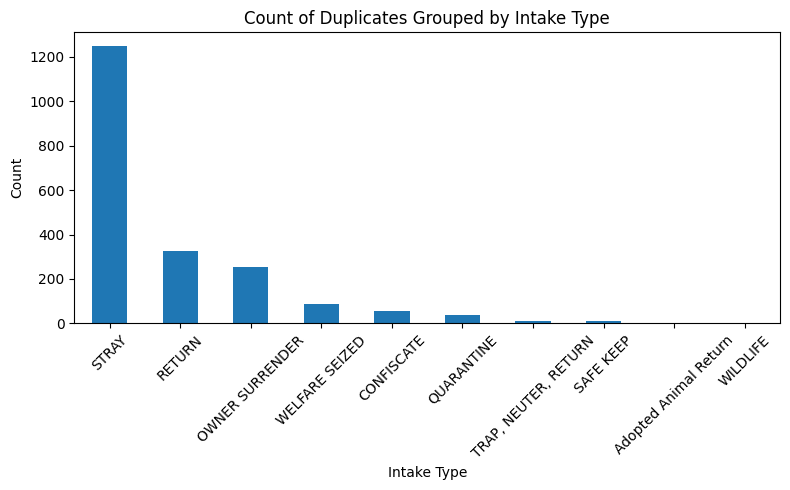

In [12]:
# 1. Histogram: count of duplicates grouped by intake_type
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_type'].value_counts().plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Count of duplicates by outcome type

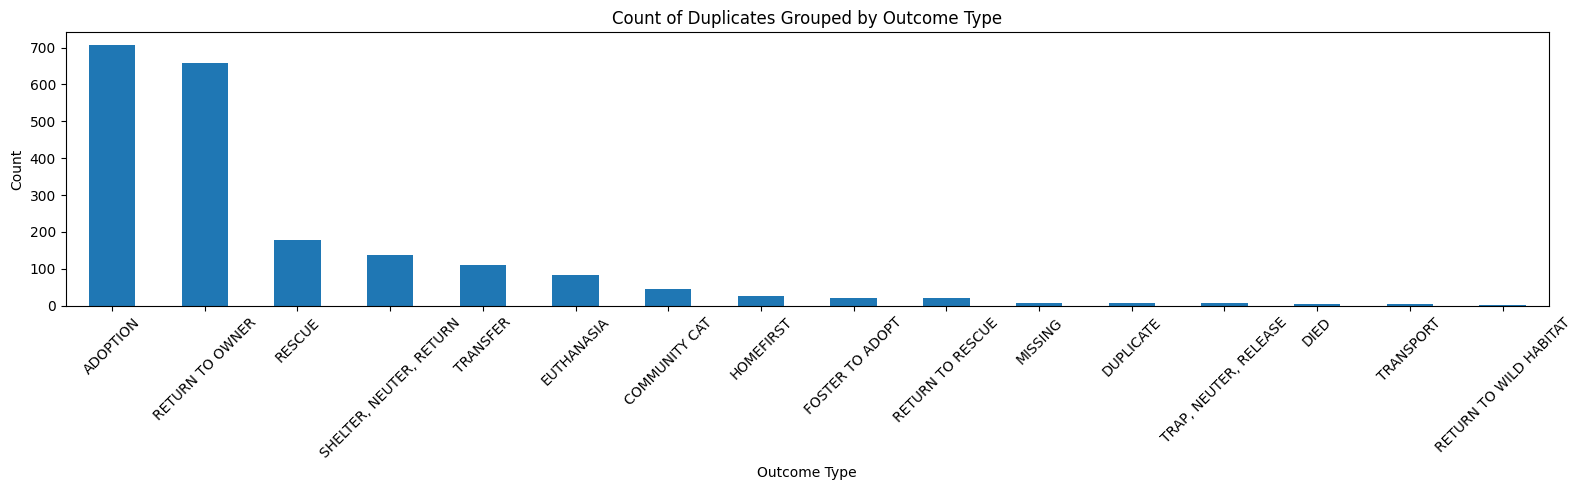

In [13]:
# 2. Histogram: count of duplicates grouped by outcome_type
plt.figure(figsize=(16, 5))
duplicates_grouped['outcome_type'].value_counts().plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Count of duplicates by intake condition

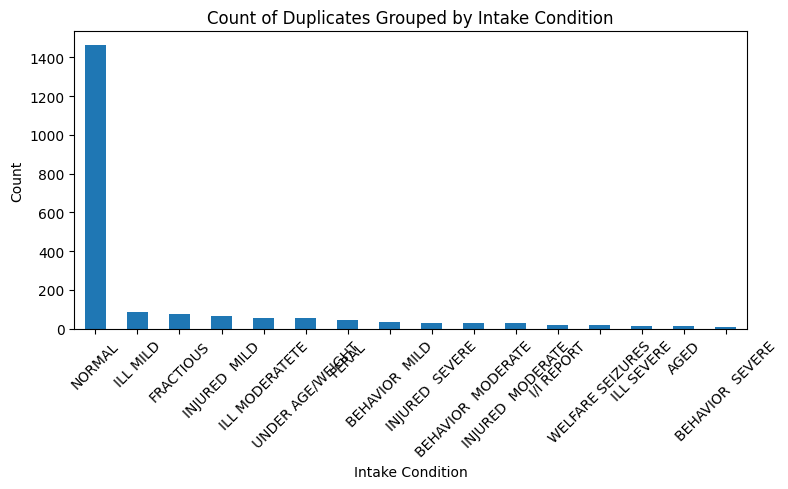

In [14]:
# 3. Histogram: count of duplicates grouped by intake_cond
plt.figure(figsize=(8, 5))
duplicates_grouped['intake_cond'].value_counts().plot(kind='bar')
plt.xlabel('Intake Condition')
plt.ylabel('Count')
plt.title('Count of Duplicates Grouped by Intake Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Find all animal_ids that are duplicated
duplicate_counts = df['animal_id'].value_counts()
duplicate_counts = duplicate_counts[duplicate_counts > 1]

# Create a DataFrame with animal_id and number of duplicates
duplicates_summary = duplicate_counts.reset_index()
duplicates_summary.columns = ['animal_id', 'number_of_duplicates']

In [16]:
duplicates_summary.describe()

,number_of_duplicates
count,934.000000
mean,2.171306
std,0.505692
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,6.000000


Insights about returned animals:
1. Most returned animals are returned twice
2. 944 animals were returned
3. Most returned animals were normal upon intake
4. 132 animals have returned more than twice

In [17]:
duplicates_summary[duplicates_summary['number_of_duplicates'] > 2]

,animal_id,number_of_duplicates
0,A657508,6
1,A606927,5
2,A575288,5
3,A609682,5
4,A599551,5
...,...,...
115,A626236,3
116,A668968,3
117,A626235,3
118,A661611,3


# Data cleaning & Processing 1

## Datetime conversion

In [18]:
# Convert *dob*, *intake_date*, *outcome_date* to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['intake_date'] = pd.to_datetime(df['intake_date'], errors='coerce')
df['outcome_date'] = pd.to_datetime(df['outcome_date'], errors='coerce')

## Adding time to outcome

In [19]:
df['time_to_outcome'] = df['outcome_date'] - df['intake_date'] # Calculate time to outcome in days

## Dealing with duplicates

In [20]:
df = df.sort_values(['animal_id', 'intake_date'])

In [21]:
# Create visit_count using groupby and cumcount
df['visit_count'] = df.groupby('animal_id').cumcount() + 1

In [22]:
# Additional useful features
df['is_return_visit'] = (df['visit_count'] > 1).astype(int)
df['is_frequent_returner'] = (df['visit_count'] > 2).astype(int)

In [23]:
# Advanced features for return animals
df['days_since_last_visit'] = df.groupby('animal_id')['intake_date'].diff().dt.days
df['days_since_last_visit'] = df['days_since_last_visit'].fillna(-1)
df['previous_outcome_type'] = df.groupby('animal_id')['outcome_type'].shift(1)
df['previous_outcome_type'] = df['previous_outcome_type'].fillna('First Visit')

# EDA pt. 1

## Return stats

In [24]:
print(f"Visit count distribution:")
print(df['visit_count'].value_counts().sort_index())
print(f"\nReturn visit rate: {df['is_return_visit'].mean():.1%}")
print(f"\nFrequent returner rate: {df['is_frequent_returner'].mean():.1%}")
print(f"\nMean days between visits: {df['days_since_last_visit'].mean():.1f}")
print(f"\nMedian days between visits: {df['days_since_last_visit'].median():.1f}")
print(f"\nMost common previous outcome for returns:")
print(df[df['is_return_visit']==1]['previous_outcome_type'].value_counts().head())

Visit count distribution:
visit_count
1    31172
2      934
3      120
4       28
5       11
6        1
Name: count, dtype: int64

Return visit rate: 3.4%

Frequent returner rate: 0.5%

Mean days between visits: 7.6

Median days between visits: -1.0

Most common previous outcome for returns:
previous_outcome_type
RETURN TO OWNER            435
ADOPTION                   401
SHELTER, NEUTER, RETURN    109
TRANSFER                    35
COMMUNITY CAT               26
Name: count, dtype: int64


## Null value analysis

In [25]:
# Percentage of null values in each column
df.isnull().mean()*100

animal_id                 0.000000
animal_name              40.742577
animal_type               0.000000
primary_color             0.000000
secondary_color          52.559970
sex                       0.000000
dob                      12.837042
intake_date               0.000000
intake_cond               0.000000
intake_type               0.000000
intake_subtype            1.348168
reason                   93.407922
outcome_date              0.771710
crossing                  0.000000
jurisdiction              0.000000
outcome_type              0.796504
outcome_subtype          11.507469
latitude                  0.000000
longitude                 0.000000
intake_is_dead            0.000000
outcome_is_dead           0.000000
was_outcome_alive         0.000000
geopoint                  0.000000
intake_duration           0.771710
is_current_month          0.000000
time_to_outcome           0.771710
visit_count               0.000000
is_return_visit           0.000000
is_frequent_returner

## MSNO matrix

<Axes: >

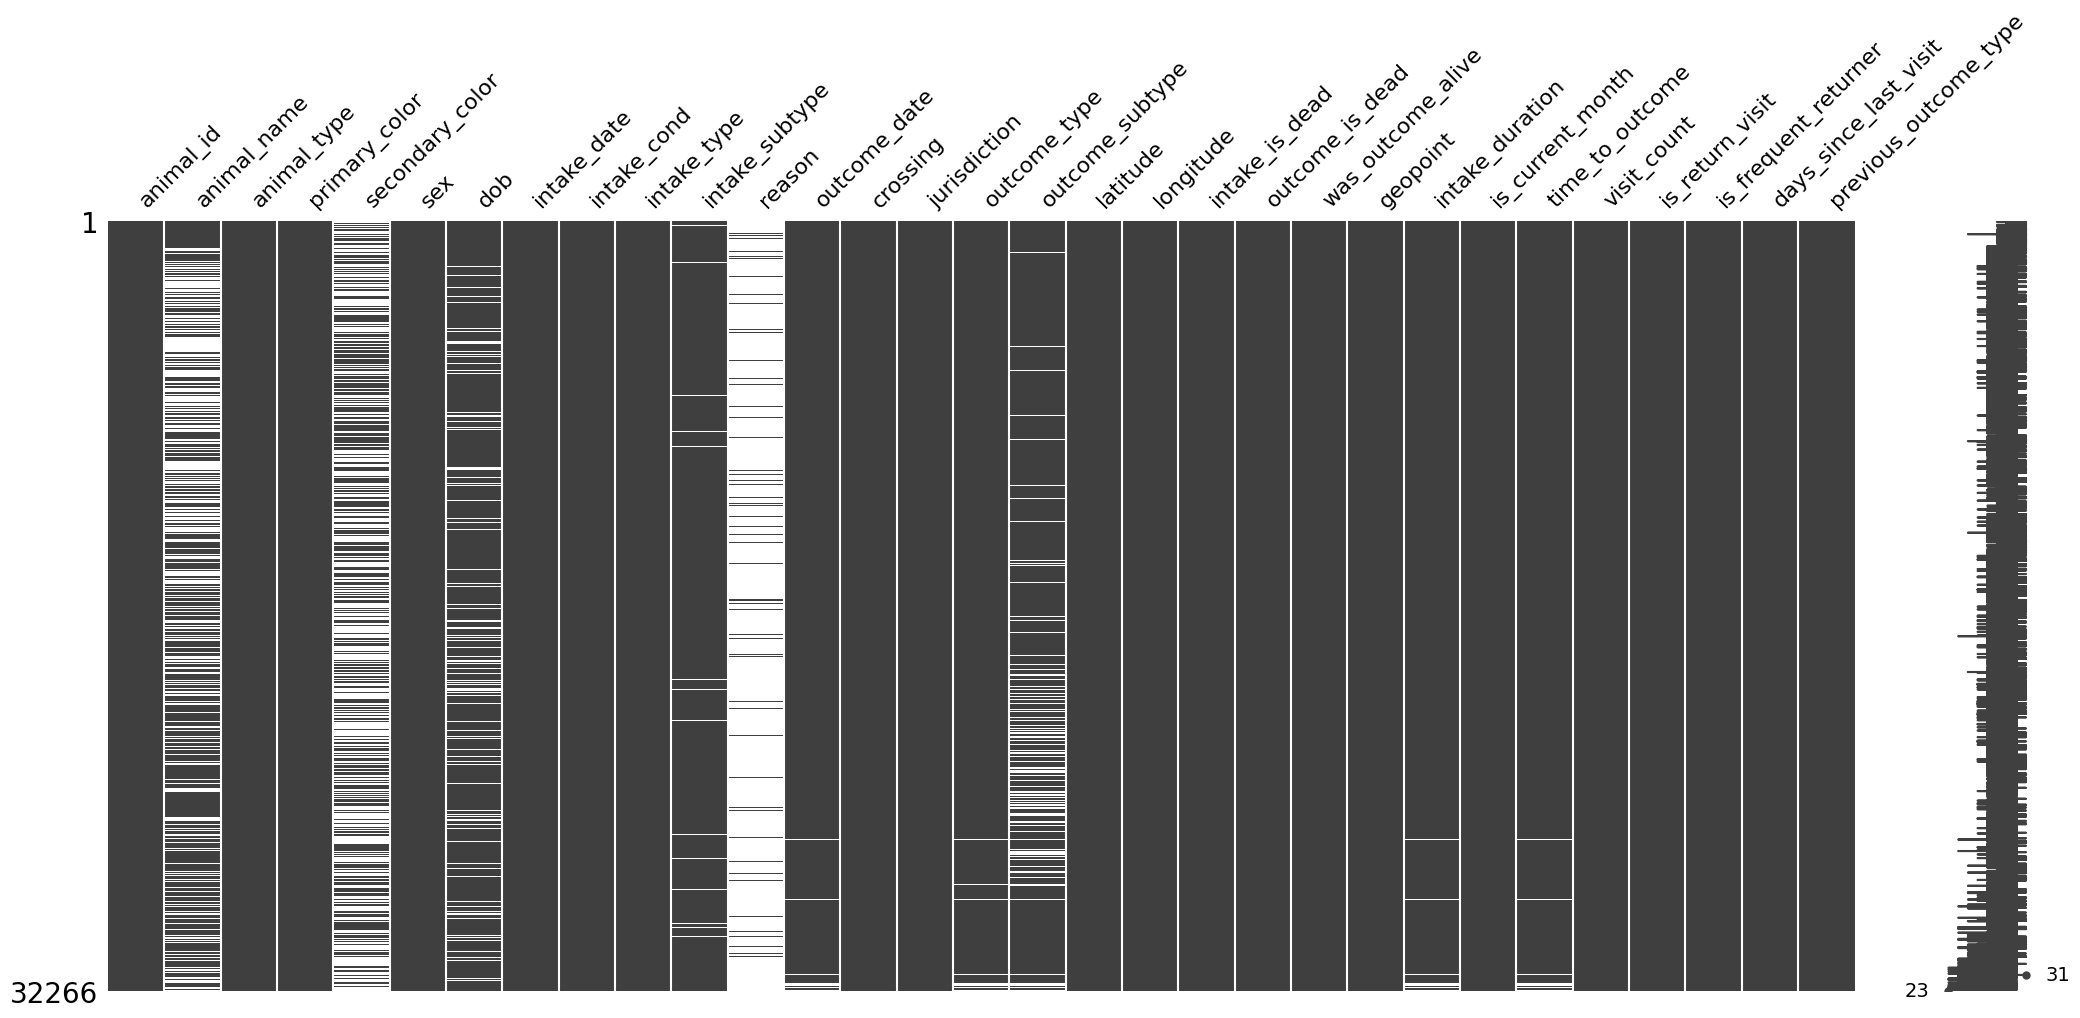

In [26]:
matrix(df)

## Outcome type count

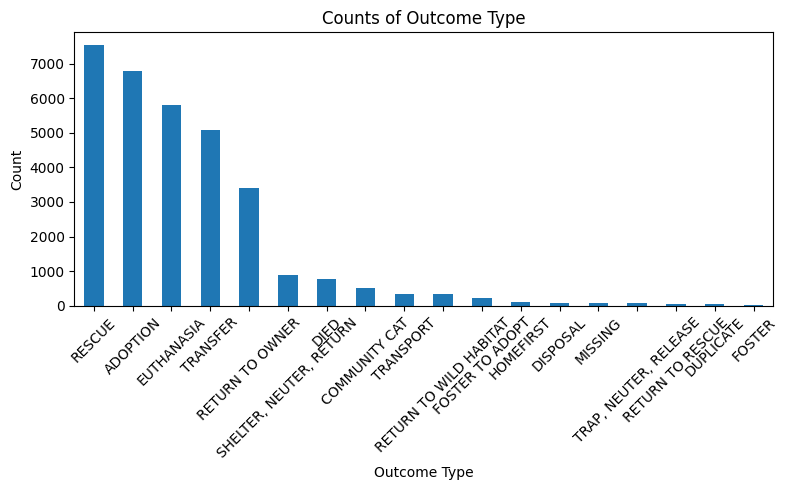

In [27]:
# Get value counts for outcome_type
counts = df['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Animal type counts

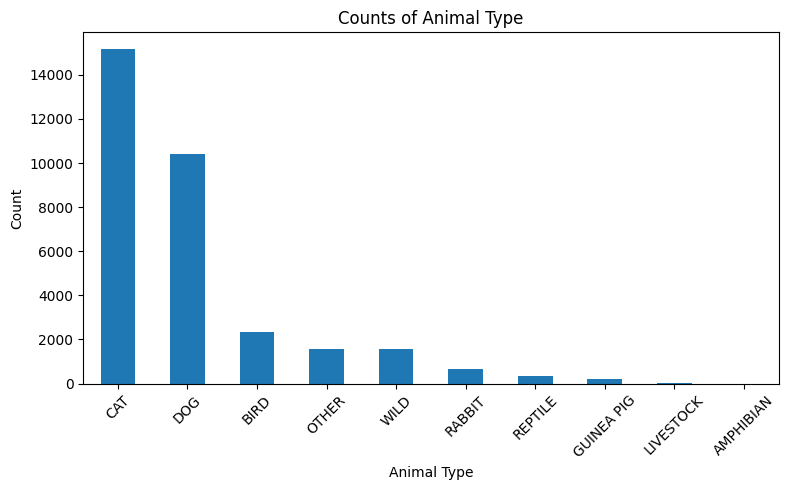

In [28]:
# Get value counts for animal_type
counts = df['animal_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Animal Type')
plt.ylabel('Count')
plt.title('Counts of Animal Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intake type count

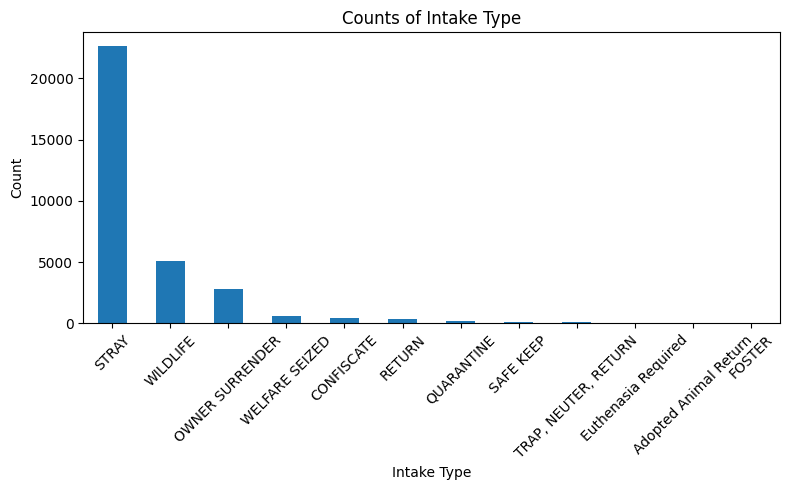

In [29]:
# Get value counts for intake_type
counts = df['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DOB null grouped by intake type

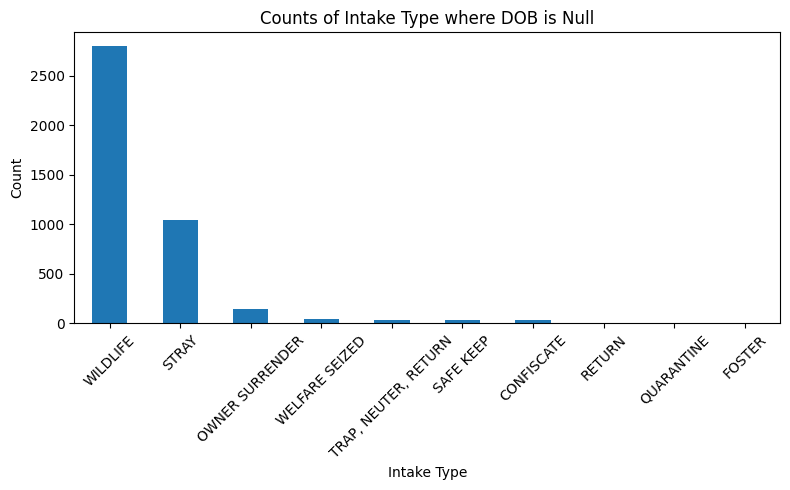

In [30]:
# Filter rows where dob is null
null_dob = df[df['dob'].isnull()]

# Get value counts for intake_type in these rows
counts = null_dob['intake_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Intake Type')
plt.ylabel('Count')
plt.title('Counts of Intake Type where DOB is Null')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
counts.head(10)

intake_type
WILDLIFE                2800
STRAY                   1042
OWNER SURRENDER          150
WELFARE SEIZED            44
TRAP, NEUTER, RETURN      34
SAFE KEEP                 33
CONFISCATE                32
RETURN                     4
QUARANTINE                 2
FOSTER                     1
Name: count, dtype: int64

# Data cleaning & Processing 2

## Statistical/Domain-knowledge based imputation for DOB

In [32]:
def impute_dob_statistical(df):
    """Impute DOB using statistical measures from similar animals"""
    df_imputed = df.copy()
    
    # Calculate age for animals with known DOB
    known_mask = df_imputed['dob'].notna()
    df_imputed.loc[known_mask, 'age_at_intake_days'] = (
        df_imputed.loc[known_mask, 'intake_date'] - df_imputed.loc[known_mask, 'dob']
    ).dt.days
    
    # Group by animal_type and intake_type for imputation
    imputation_groups = ['animal_type', 'intake_type', 'sex']
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        # Get characteristics of current animal
        animal_info = df_imputed.loc[idx]
        
        # Find similar animals with known DOB
        similar_animals = df_imputed[
            (df_imputed['animal_type'] == animal_info['animal_type']) &
            (df_imputed['intake_type'] == animal_info['intake_type']) &
            (df_imputed['sex'] == animal_info['sex']) &
            (df_imputed['dob'].notna())
        ]
        
        # If no exact match, broaden the criteria
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['intake_type'] == animal_info['intake_type']) &
                (df_imputed['dob'].notna())
            ]
        
        # If still no match, use animal_type only
        if len(similar_animals) < 5:
            similar_animals = df_imputed[
                (df_imputed['animal_type'] == animal_info['animal_type']) &
                (df_imputed['dob'].notna())
            ]
        
        if len(similar_animals) > 0:
            # Use median age of similar animals
            median_age_days = similar_animals['age_at_intake_days'].median()
            
            # FIX: Check if median is valid and convert to int
            if pd.notna(median_age_days):
                # Calculate imputed DOB
                imputed_dob = animal_info['intake_date'] - timedelta(days=int(median_age_days))
                df_imputed.loc[idx, 'dob'] = imputed_dob
                imputed_count += 1
    
    print(f"Strategy 1: Imputed DOB for {imputed_count} animals using statistical method")
    return df_imputed

def impute_dob_domain_knowledge(df):
    """Impute DOB using domain knowledge about animal shelters"""
    df_imputed = df.copy()
    
    missing_mask = df_imputed['dob'].isna()
    imputed_count = 0
    
    for idx in df_imputed[missing_mask].index:
        animal_info = df_imputed.loc[idx]
        intake_date = animal_info['intake_date']
        
        # Define typical ages based on intake type and condition
        if animal_info['intake_type'] == 'WILDLIFE':
            # Wildlife often comes in as injured adults or orphaned babies
            if 'WEIGHT' in str(animal_info['intake_cond']).upper():
                # Likely a baby if underweight
                estimated_age_days = np.random.normal(30, 15)  # 1 month ± 2 weeks
            else:
                # Likely adult wildlife
                estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
                
        elif animal_info['intake_type'] == 'STRAY':
            # Strays are often young adults who got lost
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(548, 365)  # 1.5 years ± 1 year
            else:  # DOG
                estimated_age_days = np.random.normal(730, 365)  # 2 years ± 1 year
                
        elif animal_info['intake_type'] == 'OWNER SURRENDER':
            # Owner surrenders often older animals due to life changes
            if animal_info['animal_type'] == 'CAT':
                estimated_age_days = np.random.normal(1095, 730)  # 3 years ± 2 years
            else:  # DOG
                estimated_age_days = np.random.normal(1460, 1095)  # 4 years ± 3 years
                
        else:
            # Default for other types
            estimated_age_days = np.random.normal(365, 180)  # 1 year ± 6 months
        
        # Ensure positive age and not born in the future
        estimated_age_days = max(1, estimated_age_days)
        estimated_age_days = min(estimated_age_days, 5475)  # Max 15 years
        
        # FIX: Convert to int for timedelta
        # Calculate DOB
        imputed_dob = intake_date - timedelta(days=int(estimated_age_days))
        df_imputed.loc[idx, 'dob'] = imputed_dob
        imputed_count += 1
    
    print(f"Strategy 2: Imputed DOB for {imputed_count} animals using domain knowledge")
    return df_imputed

def impute_dob_hybrid(df):
    """Combine multiple strategies for best results"""
    df_imputed = df.copy()
    
    print("Hybrid DOB Imputation Strategy:")
    print("=" * 40)
    
    # First, try statistical imputation for animals with many similar examples
    df_imputed = impute_dob_statistical(df_imputed)
    
    # Then, use domain knowledge for remaining missing values
    remaining_missing = df_imputed['dob'].isna().sum()
    if remaining_missing > 0:
        print(f"Applying domain knowledge to {remaining_missing} remaining missing DOBs")
        df_imputed = impute_dob_domain_knowledge(df_imputed)
    # Calculate age for ALL animals after imputation
    df_imputed['age_at_intake_days'] = (df_imputed['intake_date'] - df_imputed['dob']).dt.days
    
    return df_imputed

In [33]:
df = impute_dob_hybrid(df)

Hybrid DOB Imputation Strategy:
Strategy 1: Imputed DOB for 4121 animals using statistical method
Applying domain knowledge to 21 remaining missing DOBs
Strategy 2: Imputed DOB for 21 animals using domain knowledge


## Deleting values where DOB > intake_date

In [34]:
df = df[(df['dob'] <= df['intake_date']) | df['dob'].isnull() | df['intake_date'].isnull()]

## Replace null values of secondary colour

In [35]:
df['secondary_color'] = df['secondary_color'].fillna('None')

## Dropping columns *reason*, *geopoint*, *was_outcome_alive*, *animal_id*

In [36]:
df = df.drop(columns=['reason', 'geopoint', 'was_outcome_alive', 'animal_id'], axis=1)

## Adding *has_name* column

In [37]:
# New column called has_name where if animal_name is not null, then 1, else 0
df['has_name'] = df['animal_name'].notnull().astype(int)

## Drop *animal_name* column

In [38]:
df = df.drop(columns=['animal_name'])

## Dropping null values for *outcome_type*, & *intake_subtype*

In [39]:
df = df.dropna(subset=['intake_subtype', 'outcome_type'])

## Dropping *crossing*

In [40]:
df = df.drop(columns=['crossing'])

## Dropping *intake_is_dead* column

In [41]:
# Unique values in intake_is_dead
df['intake_is_dead'].unique()

array(['Alive on Intake'], dtype=object)

Can drop this column since no information is being conveyed through only 1 possible outcome here.

In [42]:
df = df.drop(columns=['intake_is_dead'], axis=1)

## Outcome_subtype Null value counts for outcome_type

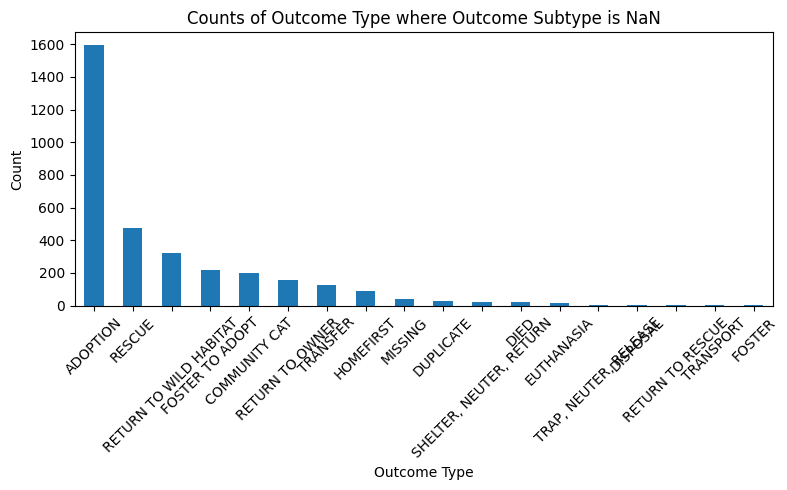

In [43]:
# Get the counts
counts = df[df['outcome_subtype'].isnull()]['outcome_type'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
counts.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Count')
plt.title('Counts of Outcome Type where Outcome Subtype is NaN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Adding *intake_month*

In [44]:
df['intake_month'] = df['intake_date'].dt.month

## Adding *is_fixed* column

In [45]:
df['is_fixed'] = df['sex'].str.contains('Spayed|Neutered', case=False, na=False).astype(int)

## Making changes to the *sex* column

Since the sex column contains the fix status, we want to change that to just male, female, and unknown options. The way we can do that is by changing "neutered" to male and "spayed" to female

In [46]:
df['sex'] = df['sex'].replace({'Neutered': 'Male', 'Spayed': 'Female'})

# Observations, changes, & notes

1. Drop the following columns: *reason*, *geopoint*, *was_outcome_alive*, *animal_id*
2. Add a *has_name* column, then drop *animal_name*
3. Replace null values in *secondary_color* to "None" so that data for animals with more colours is preserved
4. Drop missing values for *outcome_type*, *intake_subtype*, 
5. Replace missing values in *outcome_subtype* to most commonly occuring values, **after more exploration**
6. Once incorporated into LUCA, drop *latitude*, *longitude*. Use *jurisdiction*
7. Drop *crossing*, unless it helps in geospatial mapping
8. Add a *time_to_outcome* variable
9. Convert *dob*, *intake_date*, *outcome_date* to datetime
10. *outcome_date*, and *outcome_type* have values missing together. Some values in *outcome_subtype* also miss when *outcome_type* is missing.
11. Since target variable is *outcome_type*, dropping *outcome_subtype* makes sense
12. If *outcome_type* is target, remove forward looking variables like *outcome_subtype*, *time_to_outcome*, *outcome_is_dead*, *outcome_date*, 
13. Add *time_at_shelter* but carefully so as to not leak forward looking information
14. Bucket *animal_type* into cat, dog, other
15. Add *age_at_intake* column
16. Add *age_at_outcome* column

# EDA pt. 2

## Average/Median time to outcome grouped by outcome type

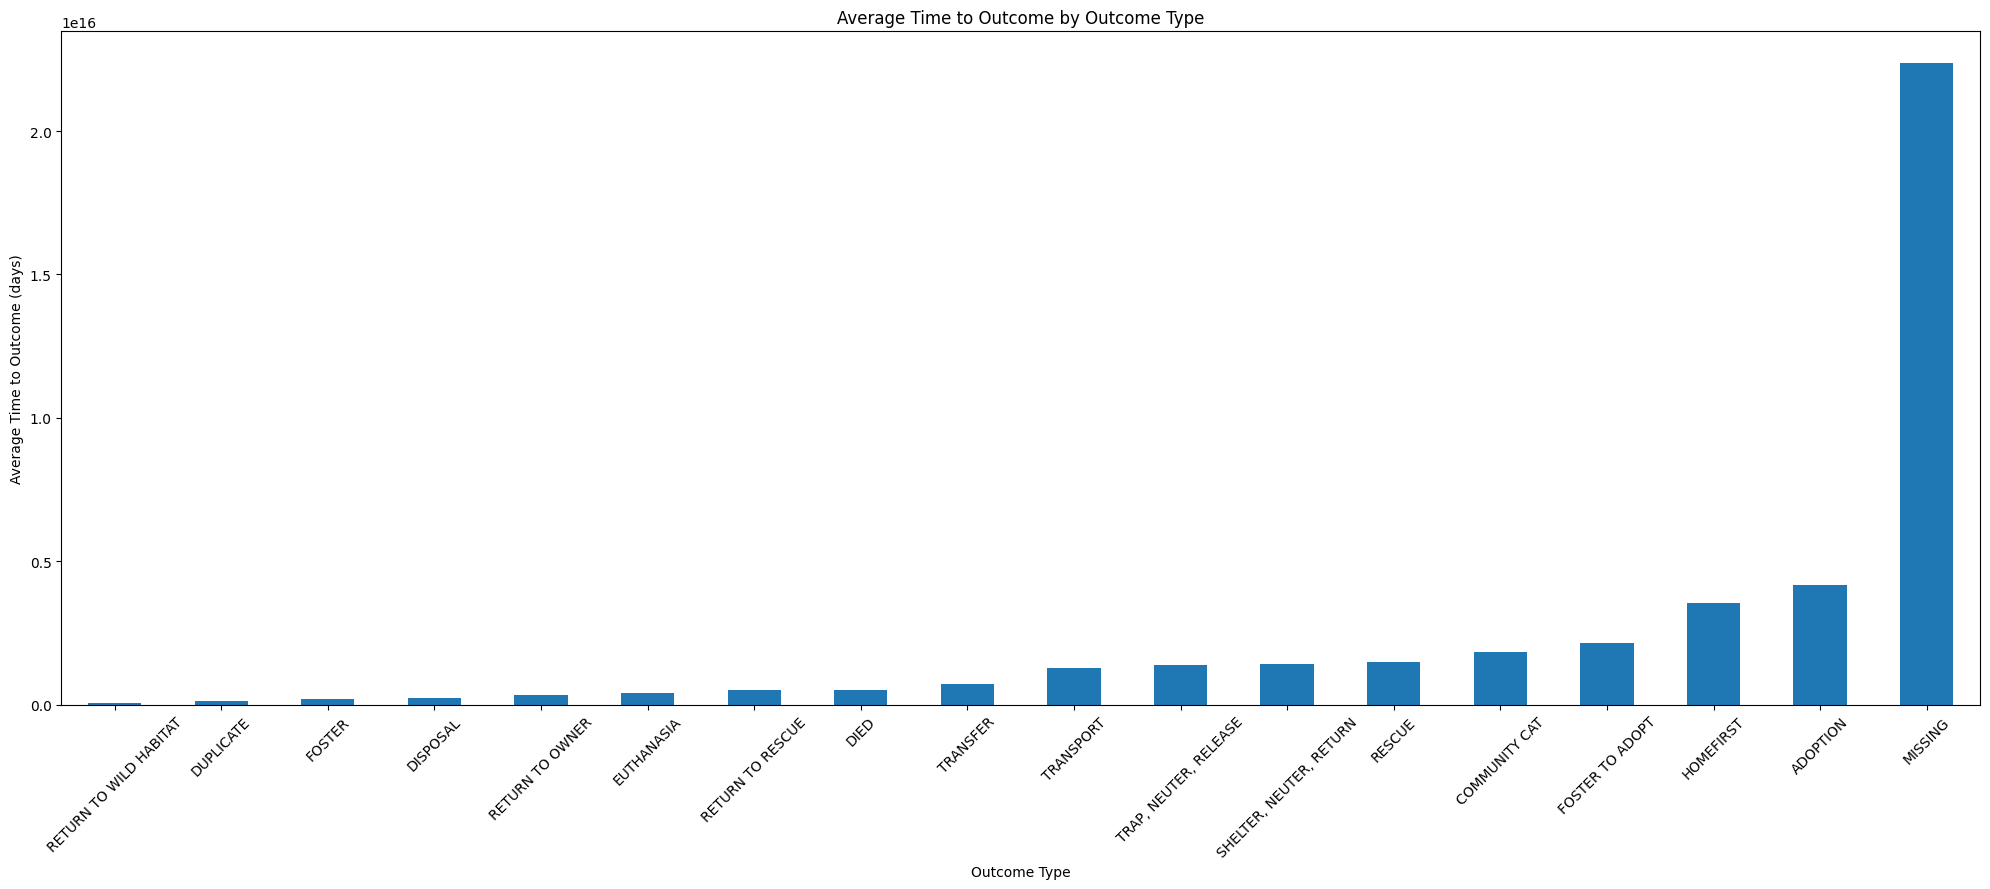

In [47]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].mean().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

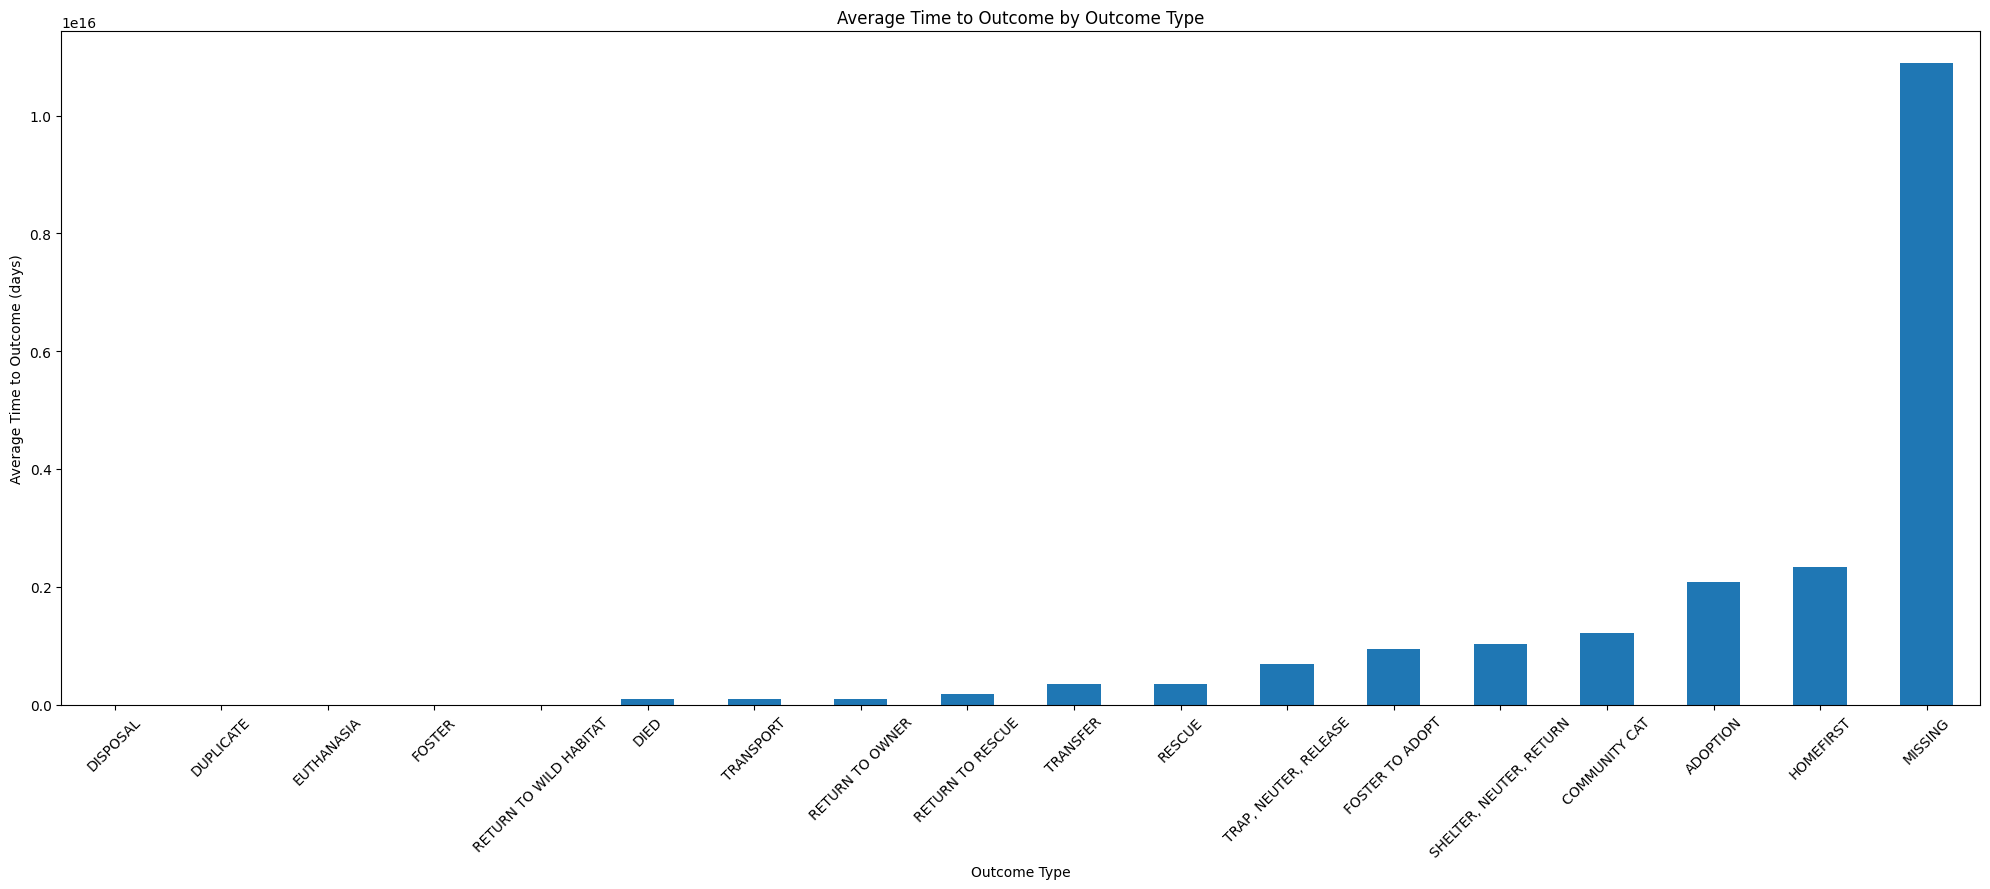

In [48]:
# Group by outcome_type and calculate the average time to outcome
avg_time = df.groupby('outcome_type')['time_to_outcome'].median().sort_values()

# Plot the histogram (bar plot)
plt.figure(figsize=(20, 9))
avg_time.plot(kind='bar')
plt.xlabel('Outcome Type')
plt.ylabel('Average Time to Outcome (days)')
plt.title('Average Time to Outcome by Outcome Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
df.head()

,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,intake_subtype,outcome_date,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,intake_duration,is_current_month,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,intake_month,is_fixed
11179,DOG,TRICOLOR,None,Female,2006-08-21,2021-06-11,AGED,STRAY,FIELD,2021-06-12,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1.0,0,1 days,1,0,0,-1.0,First Visit,5408,1,6,1
14805,DOG,WHITE,None,Female,2008-12-09,2017-07-02,NORMAL,CONFISCATE,POLICE,2017-07-03,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1.0,0,1 days,1,0,0,-1.0,First Visit,3127,1,7,1
31324,DOG,BLACK,TAN,Female,2005-11-19,2017-11-18,ILL MILD,STRAY,FIELD,2017-11-19,LONG BEACH,RETURN TO OWNER,WALKIN,33.769738,-118.181894,False,1.0,0,1 days,1,0,0,-1.0,First Visit,4382,1,11,1
3528,DOG,BROWN,None,Female,2013-02-22,2023-02-20,ILL MILD,STRAY,FIELD,2023-02-22,LONG BEACH,RETURN TO OWNER,WALKIN,33.856286,-118.179124,False,2.0,0,2 days,1,0,0,-1.0,First Visit,3650,1,2,1
4599,DOG,TAN,WHITE,Female,2005-05-20,2017-01-13,NORMAL,STRAY,FIELD,2017-01-21,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8.0,0,8 days,1,0,0,-1.0,First Visit,4256,1,1,1


## Unique value counts for each column

In [50]:
unique_counts_df = df.nunique().reset_index()
unique_counts_df.columns = ['column', 'unique_value_count']
print(unique_counts_df)

                   column  unique_value_count
0             animal_type                  10
1           primary_color                  82
2         secondary_color                  49
3                     sex                   3
4                     dob                5932
5             intake_date                3065
6             intake_cond                  16
7             intake_type                   9
8          intake_subtype                  24
9            outcome_date                3053
10           jurisdiction                  24
11           outcome_type                  18
12        outcome_subtype                 250
13               latitude                9639
14              longitude                9545
15        outcome_is_dead                   2
16        intake_duration                 387
17       is_current_month                   2
18        time_to_outcome                 387
19            visit_count                   6
20        is_return_visit         

## Null value count

In [51]:
df.isnull().sum()

animal_type                 0
primary_color               0
secondary_color             0
sex                         0
dob                         0
intake_date                 0
intake_cond                 0
intake_type                 0
intake_subtype              0
outcome_date                0
jurisdiction                0
outcome_type                0
outcome_subtype          3327
latitude                    0
longitude                   0
outcome_is_dead             0
intake_duration             0
is_current_month            0
time_to_outcome             0
visit_count                 0
is_return_visit             0
is_frequent_returner        0
days_since_last_visit       0
previous_outcome_type       0
age_at_intake_days          0
has_name                    0
intake_month                0
is_fixed                    0
dtype: int64

# Data cleaning pt. 3

## Datetime feature engineering using fastai

In [52]:
# 1. Make sure your columns are actual datetimes
for col in ['dob','intake_date','outcome_date']:
    df[col] = pd.to_datetime(df[col], utc=True)

# 2. Explode each date column into date‐parts + an “Elapsed” (epoch seconds)
for col in ['dob','intake_date','outcome_date']:
    add_datepart(df, col, drop=True)  # drop=True removes the original datetime

## Dropping redundant date columns

intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start

In [53]:
# Drop these columns: intake_month, intake_Year, intake_Month, intake_Week, intake_Day, intake_Dayofyear, intake_Is_month_end, intake_Is_month_start, intake_Is_quarter_end,intake_Is_quarter_start, intake_Is_year_end, intake_Is_year_start, outcome_Year, outcome_Month, outcome_Week, outcome_Day, outcome_Dayofyear, outcome_Is_month_end, outcome_Is_month_start, outcome_Is_quarter_end, outcome_Is_quarter_start, outcome_Is_year_end, outcome_Is_year_start, dobYear, dobMonth, dobWeek, dobDayd, obIs_month_end, dobIs_month_start, dobIs_quarter_end, dobIs_quarter_start, dobIs_year_end, dobIs_year_start
df = df.drop(columns=['intake_month', 'intake_Year', 'intake_Week', 'intake_Day', 'intake_Dayofyear', 'intake_Is_month_end', 'intake_Is_month_start', 'intake_Is_quarter_end', 'intake_Is_quarter_start', 'intake_Is_year_end', 'intake_Is_year_start', 'outcome_Year','outcome_Week', 'outcome_Day', 'outcome_Dayofyear', 'outcome_Is_month_end', 'outcome_Is_month_start', 'outcome_Is_quarter_end', 'outcome_Is_quarter_start', 'outcome_Is_year_end', 'outcome_Is_year_start', 'dobYear', 'dobWeek', 'dobDay', 'dobIs_month_end', 'dobIs_month_start', 'dobIs_quarter_end', 'dobIs_quarter_start', 'dobIs_year_end', 'dobIs_year_start', 'dobDayofyear'])

In [54]:
df.head()

,animal_type,primary_color,secondary_color,sex,intake_cond,intake_type,intake_subtype,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,outcome_is_dead,intake_duration,is_current_month,time_to_outcome,visit_count,is_return_visit,is_frequent_returner,days_since_last_visit,previous_outcome_type,age_at_intake_days,has_name,is_fixed,dobMonth,dobDayofweek,dobElapsed,intake_Month,intake_Dayofweek,intake_Elapsed,outcome_Month,outcome_Dayofweek,outcome_Elapsed
11179,DOG,TRICOLOR,None,Female,AGED,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.768077,-118.141561,False,1.0,0,1 days,1,0,0,-1.0,First Visit,5408,1,1,8,0,1.156118e+09,6,4,1.623370e+09,6,5,1.623456e+09
14805,DOG,WHITE,None,Female,NORMAL,CONFISCATE,POLICE,LONG BEACH,RETURN TO OWNER,FRE RID HM,33.757655,-118.142195,False,1.0,0,1 days,1,0,0,-1.0,First Visit,3127,1,1,12,1,1.228781e+09,7,6,1.498954e+09,7,0,1.499040e+09
31324,DOG,BLACK,TAN,Female,ILL MILD,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.769738,-118.181894,False,1.0,0,1 days,1,0,0,-1.0,First Visit,4382,1,1,11,5,1.132358e+09,11,5,1.510963e+09,11,6,1.511050e+09
3528,DOG,BROWN,None,Female,ILL MILD,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,WALKIN,33.856286,-118.179124,False,2.0,0,2 days,1,0,0,-1.0,First Visit,3650,1,1,2,4,1.361491e+09,2,0,1.676851e+09,2,2,1.677024e+09
4599,DOG,TAN,WHITE,Female,NORMAL,STRAY,FIELD,LONG BEACH,RETURN TO OWNER,MICROCHIP,33.865972,-118.192637,False,8.0,0,8 days,1,0,0,-1.0,First Visit,4256,1,1,5,4,1.116547e+09,1,4,1.484266e+09,1,5,1.484957e+09


## Correlation plot

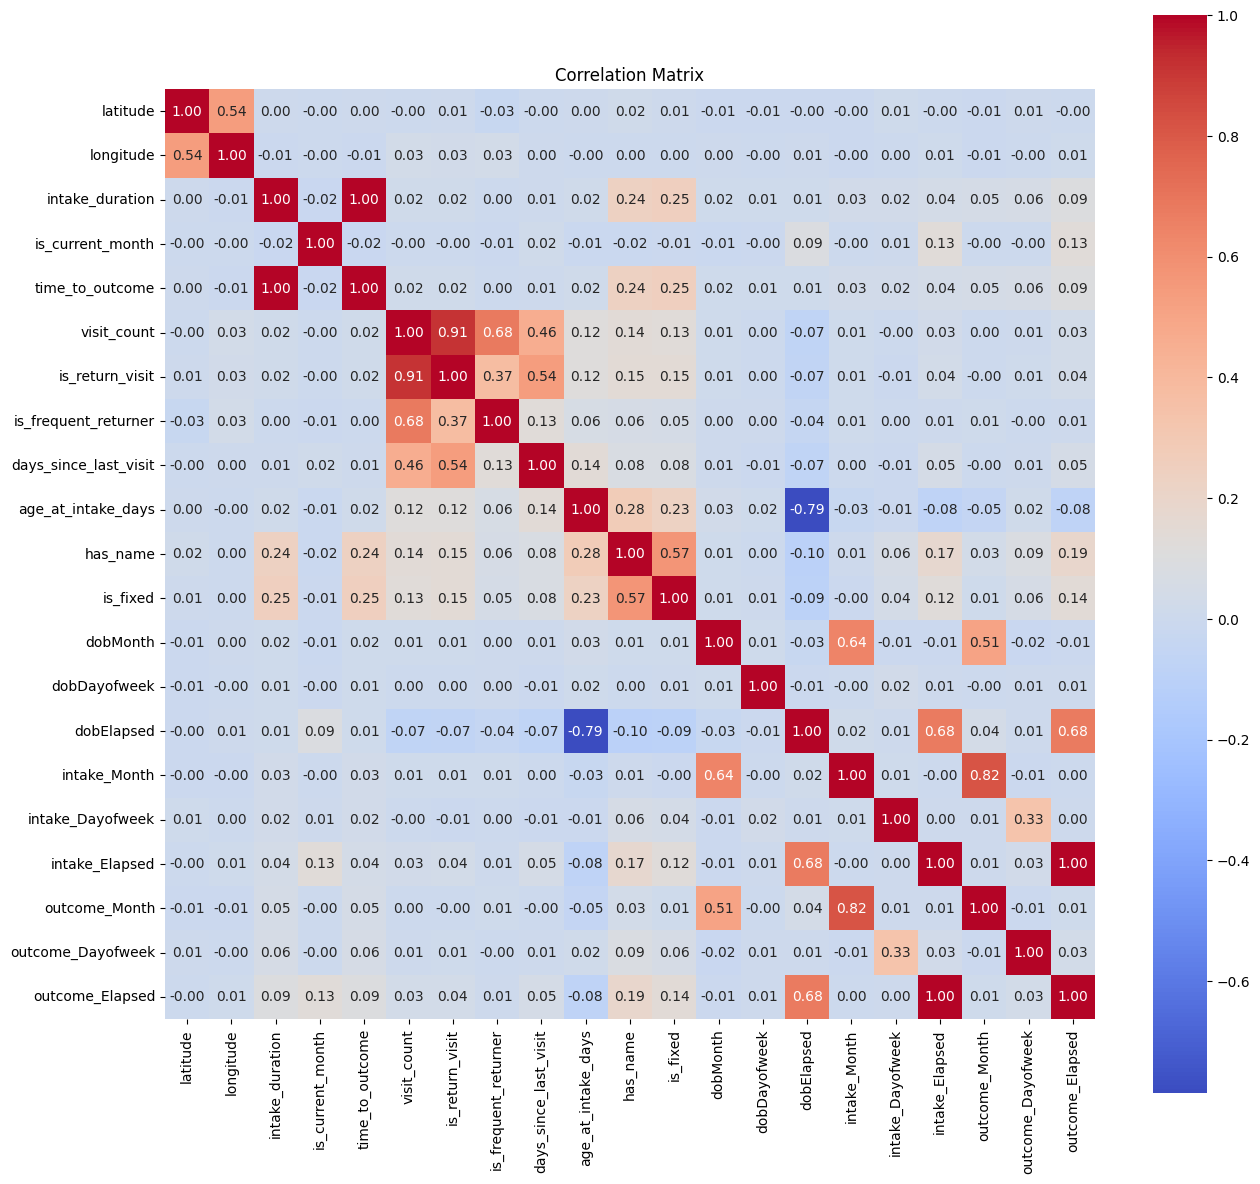

In [55]:
# Compute the correlation matrix (only numeric columns)
corr = df.select_dtypes(include='number').corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(15, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31441 entries, 11179 to 31109
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31441 non-null  object         
 1   primary_color          31441 non-null  object         
 2   secondary_color        31441 non-null  object         
 3   sex                    31441 non-null  object         
 4   intake_cond            31441 non-null  object         
 5   intake_type            31441 non-null  object         
 6   intake_subtype         31441 non-null  object         
 7   jurisdiction           31441 non-null  object         
 8   outcome_type           31441 non-null  object         
 9   outcome_subtype        28114 non-null  object         
 10  latitude               31441 non-null  float64        
 11  longitude              31441 non-null  float64        
 12  outcome_is_dead        31441 non-null  bool    

## High cardinality check

In [57]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_unique_counts = df[cat_cols].nunique()
print(cat_unique_counts.sort_values(ascending=False))

outcome_subtype          250
primary_color             82
secondary_color           49
intake_subtype            24
jurisdiction              24
outcome_type              18
intake_cond               16
previous_outcome_type     16
animal_type               10
intake_type                9
sex                        3
dtype: int64


Features with high cardinality to fix:
1. primary_color
2. secondary_color
3. outcome_type (bucket into fewer outcomes)
4. animal_type (bucket into cat, dog, other outcomes)

## List unique values for feature engineering

In [58]:
# List of unique values for primary_color
primary_colour_unique = df['primary_color'].unique()
print(primary_colour_unique)

['TRICOLOR' 'WHITE' 'BLACK' 'BROWN' 'TAN' 'BUFF' 'YELLOW' 'BLONDE' 'GRAY'
 'APRICOT' 'CREAM' 'RED' 'BR BRINDLE' 'CHOCOLATE' 'GOLD' 'BLUE' 'TORTIE'
 'BLK SMOKE' 'BRN TABBY' 'FLAME PT' 'SABLE' 'ORANGE' 'GRAY TABBY' 'FAWN'
 'BL BRINDLE' 'CHOC PT' 'ORG TABBY' 'BLUE BRIND' 'SEAL PT' 'SILVER'
 'BLUE PT' 'CALICO' 'RED MERLE' 'GREEN' 'CALICO DIL' 'SLVR TABBY'
 'TORTIE DIL' 'CRM TABBY' 'CALICO PT' 'CALICO TAB' 'SNOWSHOE' 'LYNX PT'
 'LI LYNX PT' 'LC LYNX PT' 'LIVER' 'BC LYNX PT' 'TORTIE MUT' 'PINK'
 'BLK TABBY' 'WHEAT' 'BLUE MERLE' 'BRN MERLE' 'TORTIE PT' 'S-T PT' 'TORBI'
 'ORG TIGER' 'BLUE CREAM' 'SEAL' 'GRAY TIGER' 'DAPPLE' 'UNKNOWN'
 'BRN TIGER' 'Y BRINDLE' 'LILAC PT' 'SL LYNX PT' 'BL LYNX PT' 'BLUE TABBY'
 'BLK TIGER' 'C-T PT' 'CREAM PT' 'CRM TIGER' 'B-C PT' 'LIVER TICK'
 'ST LYNX PT' 'RD LYNX PT' 'BLUE FAWN' 'CH LYNX PT' 'CR LYNX PT' 'RUDDY'
 'PEACH' 'CT LYNX PT' 'BLUE TICK']


In [59]:
# List of unique values for secondary_color
secondary_colour_unique = df['secondary_color'].unique()
print(secondary_colour_unique)

['None' 'TAN' 'WHITE' 'BLACK' 'GRAY' 'BROWN' 'RED' 'GOLD' 'CREAM' 'SILVER'
 'BLUE' 'TORTIE' 'TRICOLOR' 'BR BRINDLE' 'GREEN' 'CALICO' 'YELLOW'
 'BRN TABBY' 'ORANGE' 'ORG TABBY' 'GRAY TABBY' 'WHEAT' 'BUFF' 'PINK'
 'FLAME PT' 'LYNX PT' 'PURPLE' 'APRICOT' 'BLK SMOKE' 'TORTIE DIL'
 'SLVR TABBY' 'BL BRINDLE' 'FAWN' 'BLUE PT' 'BRN MERLE' 'CHOC PT'
 'SEAL PT' 'BLK TABBY' 'SABLE' 'BLUE BRIND' 'MARBLED TABBY' 'PEACH'
 'TORBI' 'LILAC PT' 'CALICO TABBY' 'BLUE TABBY' 'RED MERLE' 'BLUE TICK'
 'RED TICK']


In [60]:
outcome_type_unique = df['outcome_type'].unique()
print(outcome_type_unique)

['RETURN TO OWNER' 'EUTHANASIA' 'RESCUE' 'TRANSPORT' 'TRANSFER' 'ADOPTION'
 'DIED' 'DISPOSAL' 'COMMUNITY CAT' 'SHELTER, NEUTER, RETURN'
 'RETURN TO WILD HABITAT' 'RETURN TO RESCUE' 'DUPLICATE' 'HOMEFIRST'
 'MISSING' 'FOSTER' 'FOSTER TO ADOPT' 'TRAP, NEUTER, RELEASE']


In [61]:
animal_type_unique = df['animal_type'].unique()
print(animal_type_unique)

['DOG' 'CAT' 'RABBIT' 'REPTILE' 'OTHER' 'BIRD' 'LIVESTOCK' 'WILD'
 'GUINEA PIG' 'AMPHIBIAN']


## Dealing with high cardinality 

### primary_color

In [62]:
def extract_base_color_and_pattern(color):
    """Extract base color and pattern information from primary color"""
    color = str(color).upper().strip()
    
    # Define pattern keywords
    pattern_keywords = ['TABBY', 'BRINDLE', 'MERLE', 'PT', 'POINT', 'SMOKE', 'TIGER', 'LYNX']
    
    # Check if it has a pattern
    has_pattern = any(keyword in color for keyword in pattern_keywords)
    
    # Extract base color
    if color in ['TRICOLOR', 'CALICO', 'CALICO DIL', 'CALICO PT', 'CALICO TAB']:
        base_color = 'Multicolor'
    elif 'BLACK' in color or 'BLK' in color:
        base_color = 'Black'
    elif 'WHITE' in color:
        base_color = 'White'
    elif 'BROWN' in color or 'BRN' in color or 'BR ' in color:
        base_color = 'Brown'
    elif 'GRAY' in color or 'GREY' in color:
        base_color = 'Gray'
    elif 'RED' in color or 'RD ' in color:
        base_color = 'Red'
    elif 'BLUE' in color or 'BL ' in color or 'BC ' in color:
        base_color = 'Blue'
    elif 'CREAM' in color or 'CRM' in color or 'CR ' in color:
        base_color = 'Cream'
    elif 'TAN' in color:
        base_color = 'Tan'
    elif 'YELLOW' in color:
        base_color = 'Yellow'
    elif 'ORANGE' in color or 'ORG' in color:
        base_color = 'Orange'
    elif 'GOLD' in color:
        base_color = 'Gold'
    elif 'SILVER' in color or 'SLVR' in color or 'SL ' in color:
        base_color = 'Silver'
    elif 'CHOCOLATE' in color or 'CHOC' in color or 'CH ' in color:
        base_color = 'Chocolate'
    elif 'BUFF' in color:
        base_color = 'Buff'
    elif 'BLONDE' in color:
        base_color = 'Blonde'
    elif 'APRICOT' in color:
        base_color = 'Apricot'
    elif 'TORTIE' in color or 'TORBI' in color:
        base_color = 'Tortoiseshell'
    elif 'SABLE' in color:
        base_color = 'Sable'
    elif 'WHEAT' in color:
        base_color = 'Wheat'
    elif 'FAWN' in color:
        base_color = 'Fawn'
    elif 'SEAL' in color:
        base_color = 'Seal'
    elif 'LILAC' in color:
        base_color = 'Lilac'
    elif 'LIVER' in color:
        base_color = 'Liver'
    elif 'PINK' in color:
        base_color = 'Pink'
    elif 'GREEN' in color:
        base_color = 'Green'
    elif 'FLAME' in color:
        base_color = 'Flame'
    elif 'PEACH' in color:
        base_color = 'Peach'
    elif 'RUDDY' in color:
        base_color = 'Ruddy'
    elif 'DAPPLE' in color:
        base_color = 'Dapple'
    elif 'SNOWSHOE' in color:
        base_color = 'Snowshoe'
    elif 'TICK' in color:
        base_color = 'Tick'
    elif 'UNKNOWN' in color:
        base_color = 'Unknown'
    else:
        base_color = 'Other'
    
    return base_color, int(has_pattern)

# Apply transformation
print("Extracting base colors and patterns...")
primary_color_info = df['primary_color'].apply(extract_base_color_and_pattern)
df['primary_base_color'] = [info[0] for info in primary_color_info]
df['has_pattern'] = [info[1] for info in primary_color_info]

# Display results
print("Primary color transformation results:")
print(f"primary_base_color unique values: {df['primary_base_color'].nunique()}")
print("Base color distribution:")
print(df['primary_base_color'].value_counts().head(10))
print(f"\nPattern distribution:")
print(df['has_pattern'].value_counts())

Extracting base colors and patterns...
Primary color transformation results:
primary_base_color unique values: 33
Base color distribution:
primary_base_color
Black            7929
Brown            6499
Gray             5507
White            3850
Orange           1488
Tan              1476
Multicolor       1076
Tortoiseshell     664
Blue              400
Cream             332
Name: count, dtype: int64

Pattern distribution:
has_pattern
0    25710
1     5731
Name: count, dtype: int64


### secondary_color

In [63]:
# Create binary secondary color feature
df['has_secondary_color'] = (df['secondary_color'] != 'None').astype(int)

print("Secondary color transformation results:")
print("has_secondary_color distribution:")
print(df['has_secondary_color'].value_counts())
print(f"Percentage with secondary color: {df['has_secondary_color'].mean()*100:.1f}%")

print("\n" + "="*60)
print("TRANSFORMING ANIMAL TYPE")
print("="*60)

Secondary color transformation results:
has_secondary_color distribution:
has_secondary_color
0    16526
1    14915
Name: count, dtype: int64
Percentage with secondary color: 47.4%

TRANSFORMING ANIMAL TYPE


### animal_type

In [64]:
def categorize_animal_type(animal_type):
    """Categorize animal type into Cat, Dog, Other"""
    animal_type = str(animal_type).upper().strip()
    
    if animal_type == 'CAT':
        return 'Cat'
    elif animal_type == 'DOG':
        return 'Dog'
    else:  # OTHER, RABBIT, REPTILE, BIRD, LIVESTOCK, WILD, GUINEA PIG
        return 'Other'

# Apply transformation
df['animal_type_grouped'] = df['animal_type'].apply(categorize_animal_type)

print("Animal type transformation results:")
print("Original vs. Grouped:")
print(pd.crosstab(df['animal_type'], df['animal_type_grouped'], margins=True))

print("\nGrouped animal type distribution:")
print(df['animal_type_grouped'].value_counts())

Animal type transformation results:
Original vs. Grouped:
animal_type_grouped    Cat    Dog  Other    All
animal_type                                    
AMPHIBIAN                0      0      2      2
BIRD                     0      0   2339   2339
CAT                  14766      0      0  14766
DOG                      0  10061      0  10061
GUINEA PIG               0      0    199    199
LIVESTOCK                0      0     11     11
OTHER                    0      0   1561   1561
RABBIT                   0      0    612    612
REPTILE                  0      0    344    344
WILD                     0      0   1546   1546
All                  14766  10061   6614  31441

Grouped animal type distribution:
animal_type_grouped
Cat      14766
Dog      10061
Other     6614
Name: count, dtype: int64


### outcome_type

In [65]:
def categorize_outcome_type(outcome_type):
    """Categorize outcome type into 6 main categories"""
    outcome_type = str(outcome_type).upper().strip()
    
    if outcome_type == 'RESCUE':
        return 'Rescue'
    elif outcome_type == 'ADOPTION':
        return 'Adoption'
    elif outcome_type == 'EUTHANASIA':
        return 'Euthanasia'
    elif outcome_type == 'TRANSFER':
        return 'Transfer'
    elif outcome_type == 'RETURN TO OWNER':
        return 'Return to Owner'
    else:  # All other outcomes go to 'Other'
        return 'Other'

# Apply transformation
df['outcome_type_grouped'] = df['outcome_type'].apply(categorize_outcome_type)

print("Outcome type transformation results:")
print("Original vs. Grouped mapping:")
outcome_mapping = df.groupby('outcome_type')['outcome_type_grouped'].first().sort_values()
for original, grouped in outcome_mapping.items():
    count = (df['outcome_type'] == original).sum()
    print(f"  {original} → {grouped} ({count:,} records)")

print("\nGrouped outcome type distribution:")
grouped_counts = df['outcome_type_grouped'].value_counts()
for outcome, count in grouped_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {outcome}: {count:,} ({percentage:.1f}%)")

Outcome type transformation results:
Original vs. Grouped mapping:
  ADOPTION → Adoption (6,676 records)
  EUTHANASIA → Euthanasia (5,713 records)
  SHELTER, NEUTER, RETURN → Other (871 records)
  RETURN TO WILD HABITAT → Other (321 records)
  RETURN TO RESCUE → Other (43 records)
  MISSING → Other (69 records)
  TRANSPORT → Other (334 records)
  HOMEFIRST → Other (88 records)
  FOSTER → Other (12 records)
  DUPLICATE → Other (31 records)
  DISPOSAL → Other (80 records)
  DIED → Other (744 records)
  COMMUNITY CAT → Other (489 records)
  FOSTER TO ADOPT → Other (222 records)
  TRAP, NEUTER, RELEASE → Other (6 records)
  RESCUE → Rescue (7,417 records)
  RETURN TO OWNER → Return to Owner (3,265 records)
  TRANSFER → Transfer (5,060 records)

Grouped outcome type distribution:
  Rescue: 7,417 (23.6%)
  Adoption: 6,676 (21.2%)
  Euthanasia: 5,713 (18.2%)
  Transfer: 5,060 (16.1%)
  Other: 3,310 (10.5%)
  Return to Owner: 3,265 (10.4%)


# Isolation forest

## Feature engineering

In [66]:
df['time_to_outcome_days'] = df['time_to_outcome'].dt.total_seconds() / (24 * 3600)

## Categorical columns

In [67]:
# Define categorical variables for encoding
categorical_columns = ['animal_type', 'primary_color', 'secondary_color', 'sex', 
                      'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction',
                      'outcome_type', 'previous_outcome_type']


In [68]:
# Label encode categorical variables
label_encoders = {}
df_encoded = df.copy()

In [69]:
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

## Selecting features for isolation forest

In [70]:
feature_columns = [
    # Encoded categorical features
    'animal_type_encoded', 'primary_color_encoded', 'secondary_color_encoded', 
    'sex_encoded', 'intake_cond_encoded', 'intake_type_encoded', 
    'intake_subtype_encoded', 'jurisdiction_encoded', 'outcome_type_encoded', 
    'previous_outcome_type_encoded',
    # Numerical features
    'latitude', 'longitude', 'outcome_is_dead', 'visit_count', 'is_return_visit',
    'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days',
    'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed',
    'intake_Month', 'intake_Dayofweek', 'intake_Elapsed', 'outcome_Month',
    'outcome_Dayofweek', 'outcome_Elapsed', 'time_to_outcome_days'
]

In [71]:
# Create feature matrix
X = df_encoded[feature_columns].copy()

In [72]:
# Convert boolean to int
X['outcome_is_dead'] = X['outcome_is_dead'].astype(int)

## Running isolation forest

Feature matrix shape: (31441, 30)
Features used: 30

Isolation Forest Results:
Total samples: 31441
Outliers detected: 315 (1.00%)
Inliers: 31126 (99.00%)


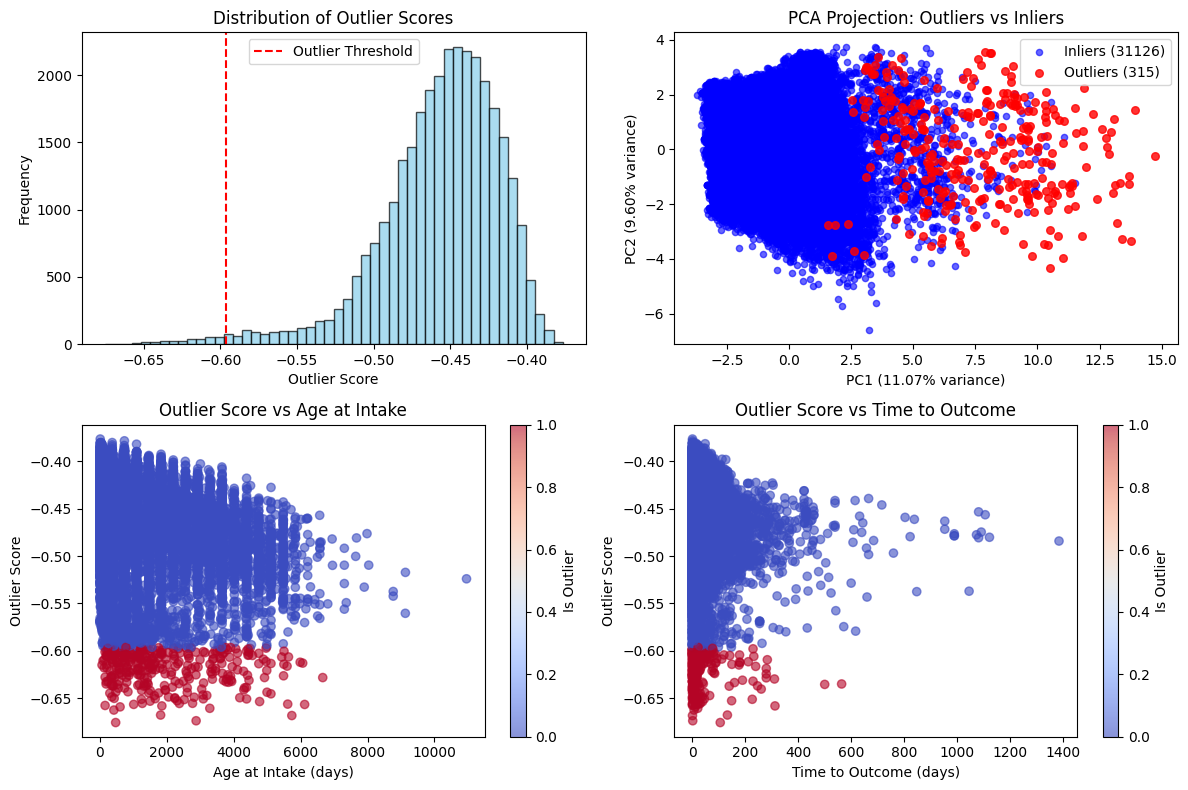


Top 10 Outliers (lowest scores):
      animal_type            outcome_type  age_at_intake_days  time_to_outcome_days  visit_count  outlier_score
24608         DOG                ADOPTION                 469                 105.0            3      -0.675713
22433         DOG              EUTHANASIA                2874                   1.0            4      -0.673820
12351         DOG         RETURN TO OWNER                5735                   0.0            4      -0.668323
6279          DOG                ADOPTION                1813                 132.0            3      -0.667790
20625         DOG                ADOPTION                 415                   6.0            4      -0.662521
27125         CAT              EUTHANASIA                3283                  20.0            3      -0.660691
10350         DOG              EUTHANASIA                 601                  10.0            2      -0.659190
22762         DOG                ADOPTION                1850         

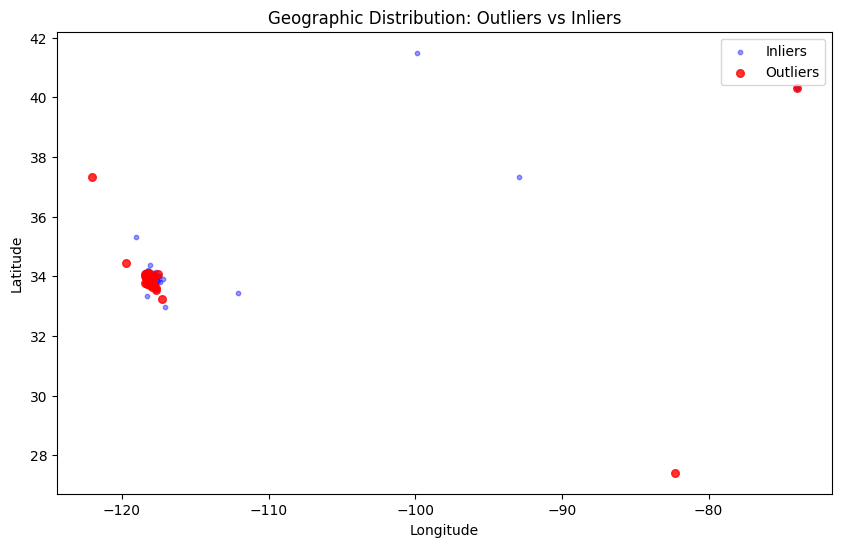


Isolation Forest completed!
Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns


In [73]:
print("Feature matrix shape:", X.shape)
print("Features used:", len(feature_columns))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
# contamination parameter: expected proportion of outliers (adjust as needed)
isolation_forest = IsolationForest(
    contamination=0.01,  # Expect 5% outliers
    random_state=42,
    n_estimators=100
)

# Fit and predict
outlier_labels = isolation_forest.fit_predict(X_scaled)
outlier_scores = isolation_forest.score_samples(X_scaled)

# Add results to dataframe
df_encoded['outlier_label'] = outlier_labels
df_encoded['outlier_score'] = outlier_scores
df_encoded['is_outlier'] = (outlier_labels == -1)

# Print results summary
n_outliers = sum(outlier_labels == -1)
n_inliers = sum(outlier_labels == 1)
outlier_percentage = (n_outliers / len(df_encoded)) * 100

print(f"\nIsolation Forest Results:")
print(f"Total samples: {len(df_encoded)}")
print(f"Outliers detected: {n_outliers} ({outlier_percentage:.2f}%)")
print(f"Inliers: {n_inliers} ({100-outlier_percentage:.2f}%)")

# Visualization 1: Outlier Score Distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(outlier_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=outlier_scores[outlier_labels == -1].max(), color='red', 
           linestyle='--', label=f'Outlier Threshold')
plt.xlabel('Outlier Score')
plt.ylabel('Frequency')
plt.title('Distribution of Outlier Scores')
plt.legend()

# Visualization 2: PCA projection for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.subplot(2, 2, 2)
inlier_mask = outlier_labels == 1
outlier_mask = outlier_labels == -1

plt.scatter(X_pca[inlier_mask, 0], X_pca[inlier_mask, 1], 
           c='blue', alpha=0.6, s=20, label=f'Inliers ({n_inliers})')
plt.scatter(X_pca[outlier_mask, 0], X_pca[outlier_mask, 1], 
           c='red', alpha=0.8, s=30, label=f'Outliers ({n_outliers})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Projection: Outliers vs Inliers')
plt.legend()

# Visualization 3: Outlier scores vs some key features
plt.subplot(2, 2, 3)
plt.scatter(df_encoded['age_at_intake_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Age at Intake (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Age at Intake')
plt.colorbar(label='Is Outlier')

plt.subplot(2, 2, 4)
plt.scatter(df_encoded['time_to_outcome_days'], outlier_scores, 
           c=df_encoded['is_outlier'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Time to Outcome (days)')
plt.ylabel('Outlier Score')
plt.title('Outlier Score vs Time to Outcome')
plt.colorbar(label='Is Outlier')

plt.tight_layout()
plt.show()

# Additional analysis: Top outliers
print("\nTop 10 Outliers (lowest scores):")
top_outliers = df_encoded[df_encoded['is_outlier']].nsmallest(10, 'outlier_score')
print(top_outliers[['animal_type', 'outcome_type', 'age_at_intake_days', 
                   'time_to_outcome_days', 'visit_count', 'outlier_score']].to_string())

# Feature importance analysis (based on outlier characteristics)
print("\nOutlier vs Inlier Comparison (mean values):")
comparison_features = ['age_at_intake_days', 'time_to_outcome_days', 'visit_count', 
                      'days_since_last_visit', 'is_frequent_returner']

outlier_means = df_encoded[df_encoded['is_outlier']][comparison_features].mean()
inlier_means = df_encoded[~df_encoded['is_outlier']][comparison_features].mean()

comparison_df = pd.DataFrame({
    'Outliers': outlier_means,
    'Inliers': inlier_means,
    'Difference': outlier_means - inlier_means
})
print(comparison_df.round(2))

# Categorical feature analysis for outliers
print("\nCategorical Feature Distribution in Outliers:")
categorical_analysis = ['animal_type', 'outcome_type', 'intake_type']
for feature in categorical_analysis:
    print(f"\n{feature} distribution in outliers:")
    outlier_dist = df_encoded[df_encoded['is_outlier']][feature].value_counts().head()
    total_dist = df_encoded[feature].value_counts().head()
    print("Outliers:", outlier_dist.to_dict())
    print("Overall:", total_dist.to_dict())

# Geographic outliers visualization
plt.figure(figsize=(10, 6))
plt.scatter(df_encoded[~df_encoded['is_outlier']]['longitude'], 
           df_encoded[~df_encoded['is_outlier']]['latitude'], 
           c='blue', alpha=0.4, s=10, label='Inliers')
plt.scatter(df_encoded[df_encoded['is_outlier']]['longitude'], 
           df_encoded[df_encoded['is_outlier']]['latitude'], 
           c='red', alpha=0.8, s=30, label='Outliers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution: Outliers vs Inliers')
plt.legend()
plt.show()

print(f"\nIsolation Forest completed!")
print(f"Outlier detection results added to dataframe as 'is_outlier' and 'outlier_score' columns")

# Clustering

For clustering, let's try 3 algorithms:
1. K-Prototype clustering: Great for hybrid data with categorical and numerical features
2. Hierarchical clustering with Gower distance: No need for encoding categorical features
3. DBSCAN with gower distance: Density based clustering option

## Preprocessing

In [74]:
# Data preprocessing - Drop outcome-related features
features_to_drop = [
    'outcome_type', 'outcome_subtype', 'outcome_is_dead', 
    'time_to_outcome', 'time_to_outcome_days',
    'outcome_Month', 'outcome_Dayofweek', 'outcome_Elapsed'
]

# Keep all other features
df_cluster = df.drop(columns=[col for col in features_to_drop if col in df.columns], errors='ignore')

In [75]:
df_cluster = df_cluster[df_cluster['jurisdiction'].notna()]

In [77]:
# Identify categorical and numerical columns
categorical_cols = df_cluster.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_cluster.select_dtypes(include=['number', 'bool']).columns.tolist()

print(f"\nCategorical features ({len(categorical_cols)}):", categorical_cols)
print(f"Numerical features ({len(numerical_cols)}):", numerical_cols)

# Prepare data for clustering
X_cluster = df_cluster.copy()

# Convert boolean columns to int for consistency
for col in X_cluster.columns:
    if X_cluster[col].dtype == 'bool':
        X_cluster[col] = X_cluster[col].astype(int)

# Update numerical columns list after boolean conversion
numerical_cols = X_cluster.select_dtypes(include=['number']).columns.tolist()

print(f"Final numerical features: {len(numerical_cols)}")
print(f"Final categorical features: {len(categorical_cols)}")


Categorical features (12): ['animal_type', 'primary_color', 'secondary_color', 'sex', 'intake_cond', 'intake_type', 'intake_subtype', 'jurisdiction', 'previous_outcome_type', 'primary_base_color', 'animal_type_grouped', 'outcome_type_grouped']
Numerical features (19): ['latitude', 'longitude', 'intake_duration', 'is_current_month', 'visit_count', 'is_return_visit', 'is_frequent_returner', 'days_since_last_visit', 'age_at_intake_days', 'has_name', 'is_fixed', 'dobMonth', 'dobDayofweek', 'dobElapsed', 'intake_Month', 'intake_Dayofweek', 'intake_Elapsed', 'has_pattern', 'has_secondary_color']
Final numerical features: 19
Final categorical features: 12


## K-Prototype clustering

In [ ]:
# Test different numbers of clusters for K-Prototypes
k_range = range(2, 11)
kproto_silhouette_scores = []
kproto_costs = []
kproto_models = {}

# Determine categorical feature indices for K-Prototypes
categorical_indices = [X_cluster.columns.get_loc(col) for col in categorical_cols]

print("Testing K-Prototypes with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit K-Prototypes
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0, random_state=42)
    cluster_labels = kproto.fit_predict(X_cluster.values, categorical=categorical_indices)
    
    # Calculate silhouette score using Gower distance
    gower_dist = gower.gower_matrix(X_cluster)
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric='precomputed')
    
    kproto_silhouette_scores.append(silhouette_avg)
    kproto_costs.append(kproto.cost_)
    kproto_models[k] = (kproto, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}, Cost = {kproto.cost_:.2f}")

# Find optimal K for K-Prototypes
optimal_k_kproto = k_range[np.argmax(kproto_silhouette_scores)]
best_kproto_model, best_kproto_labels = kproto_models[optimal_k_kproto]

print(f"\nOptimal K for K-Prototypes: {optimal_k_kproto}")
print(f"Best Silhouette Score: {max(kproto_silhouette_scores):.4f}")

Testing K-Prototypes with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.0448, Cost = 291101076403981418496.00
Testing K=3...


## Gower distance matrix calculation

In [78]:
print("\n" + "="*60)
print("COMPUTING GOWER DISTANCE MATRIX")
print("="*60)

print("Computing Gower distance matrix...")
# Sample data if too large (Gower distance computation can be memory intensive)
if len(X_cluster) > 5000:
    print(f"Sampling 5000 rows from {len(X_cluster)} for distance computation...")
    sample_indices = np.random.choice(len(X_cluster), 5000, replace=False)
    X_sample = X_cluster.iloc[sample_indices]
    gower_dist_matrix = gower.gower_matrix(X_sample)
else:
    X_sample = X_cluster
    sample_indices = np.arange(len(X_cluster))
    gower_dist_matrix = gower.gower_matrix(X_sample)

print(f"Gower distance matrix shape: {gower_dist_matrix.shape}")



COMPUTING GOWER DISTANCE MATRIX
Computing Gower distance matrix...
Sampling 5000 rows from 31441 for distance computation...
Gower distance matrix shape: (5000, 5000)


## DBSCAN

In [79]:
print("\n" + "="*60)
print("DBSCAN WITH GOWER DISTANCE")
print("="*60)

# Test different epsilon values for DBSCAN
epsilon_range = np.arange(0.1, 1.0, 0.1)
dbscan_silhouette_scores = []
dbscan_n_clusters = []
dbscan_models = {}

print("Testing DBSCAN with different epsilon values...")
for eps in epsilon_range:
    print(f"Testing eps={eps:.2f}...")
    
    # Fit DBSCAN with precomputed Gower distance
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='precomputed')
    cluster_labels = dbscan.fit_predict(gower_dist_matrix)
    
    # Count clusters (excluding noise points labeled as -1)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    dbscan_n_clusters.append(n_clusters)
    
    # Calculate silhouette score (only if we have more than 1 cluster)
    if n_clusters > 1:
        # Remove noise points for silhouette calculation
        mask = cluster_labels != -1
        if np.sum(mask) > 1:
            silhouette_avg = silhouette_score(gower_dist_matrix[mask][:, mask], 
                                            cluster_labels[mask], metric='precomputed')
        else:
            silhouette_avg = -1
    else:
        silhouette_avg = -1
    
    dbscan_silhouette_scores.append(silhouette_avg)
    dbscan_models[eps] = (dbscan, cluster_labels)
    
    print(f"eps={eps:.2f}: Clusters = {n_clusters}, Noise = {n_noise}, Silhouette = {silhouette_avg:.4f}")

# Find optimal epsilon for DBSCAN
valid_scores = [score for score in dbscan_silhouette_scores if score > -1]
if valid_scores:
    optimal_eps_idx = np.argmax(dbscan_silhouette_scores)
    optimal_eps = epsilon_range[optimal_eps_idx]
    best_dbscan_model, best_dbscan_labels = dbscan_models[optimal_eps]
    
    print(f"\nOptimal epsilon for DBSCAN: {optimal_eps:.2f}")
    print(f"Best Silhouette Score: {max(dbscan_silhouette_scores):.4f}")
    print(f"Number of clusters: {dbscan_n_clusters[optimal_eps_idx]}")
else:
    print("No valid DBSCAN clustering found with given epsilon range")


DBSCAN WITH GOWER DISTANCE
Testing DBSCAN with different epsilon values...
Testing eps=0.10...
eps=0.10: Clusters = 15, Noise = 1570, Silhouette = -0.1657
Testing eps=0.20...
eps=0.20: Clusters = 1, Noise = 30, Silhouette = -1.0000
Testing eps=0.30...
eps=0.30: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.40...
eps=0.40: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.50...
eps=0.50: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.60...
eps=0.60: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.70...
eps=0.70: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.80...
eps=0.80: Clusters = 1, Noise = 0, Silhouette = -1.0000
Testing eps=0.90...
eps=0.90: Clusters = 1, Noise = 0, Silhouette = -1.0000

Optimal epsilon for DBSCAN: 0.10
Best Silhouette Score: -0.1657
Number of clusters: 15


## Hierarchical clustering

In [81]:
print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING WITH GOWER DISTANCE")
print("="*60)
k_range = range(2, 11)
# Perform hierarchical clustering with different numbers of clusters
hierarchical_silhouette_scores = []
hierarchical_models = {}

print("Testing Hierarchical clustering with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    # Fit Agglomerative Clustering with precomputed distance
    hierarchical = AgglomerativeClustering(n_clusters=k, metric='euclidean', 
                                         linkage='average')
    cluster_labels = hierarchical.fit_predict(gower_dist_matrix)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(gower_dist_matrix, cluster_labels, metric='precomputed')
    
    hierarchical_silhouette_scores.append(silhouette_avg)
    hierarchical_models[k] = (hierarchical, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal K for Hierarchical clustering
optimal_k_hierarchical = k_range[np.argmax(hierarchical_silhouette_scores)]
best_hierarchical_model, best_hierarchical_labels = hierarchical_models[optimal_k_hierarchical]

print(f"\nOptimal K for Hierarchical: {optimal_k_hierarchical}")
print(f"Best Silhouette Score: {max(hierarchical_silhouette_scores):.4f}")


HIERARCHICAL CLUSTERING WITH GOWER DISTANCE
Testing Hierarchical clustering with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.1890
Testing K=3...
K=3: Silhouette Score = 0.1719
Testing K=4...
K=4: Silhouette Score = 0.1614
Testing K=5...
K=5: Silhouette Score = 0.2043
Testing K=6...
K=6: Silhouette Score = 0.1961
Testing K=7...
K=7: Silhouette Score = 0.1768
Testing K=8...
K=8: Silhouette Score = 0.1671
Testing K=9...
K=9: Silhouette Score = 0.1673
Testing K=10...
K=10: Silhouette Score = 0.1590

Optimal K for Hierarchical: 5
Best Silhouette Score: 0.2043


## Visual insights from clustering


CREATING VISUALIZATIONS


NameError: name 'kproto_silhouette_scores' is not defined

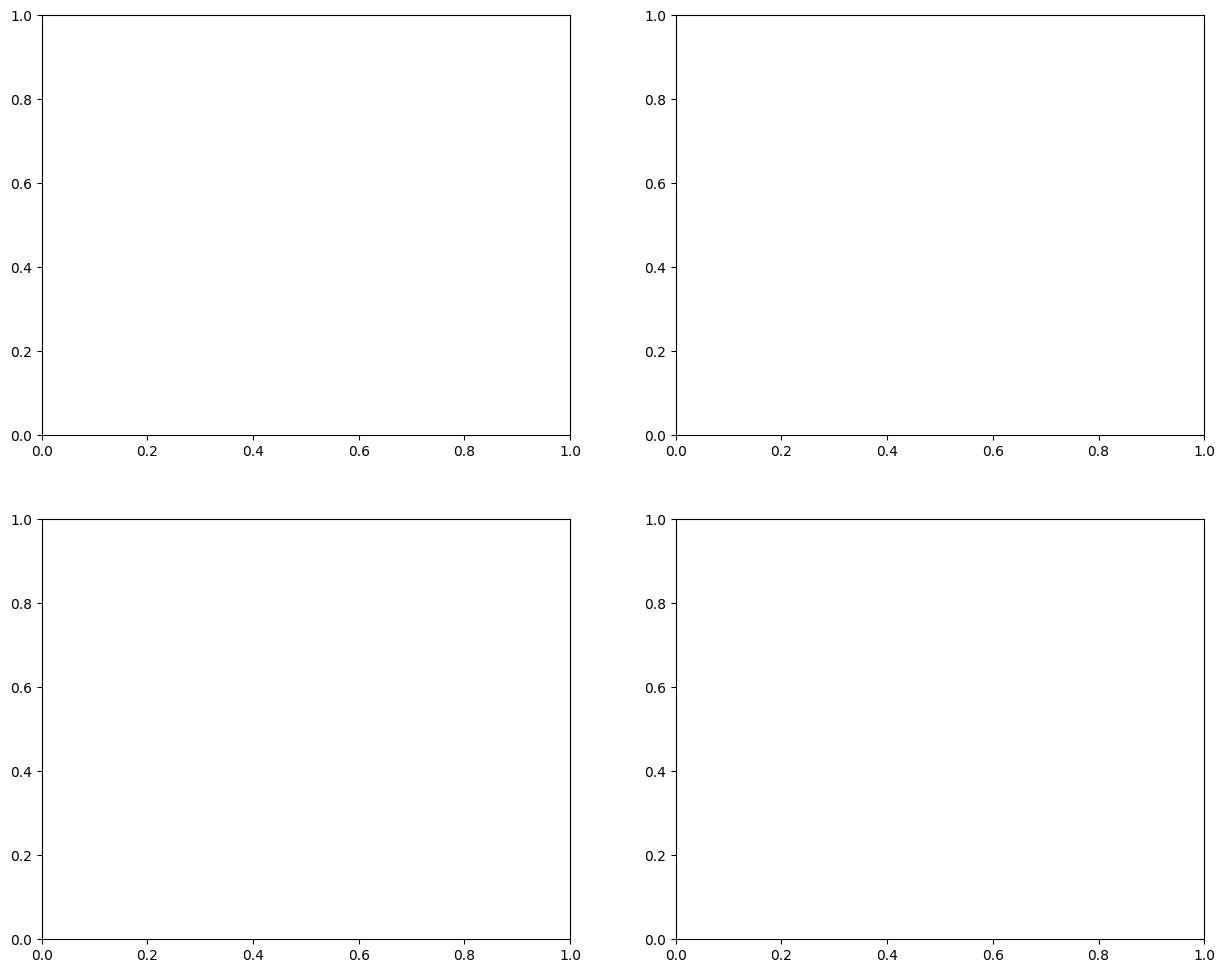

In [82]:
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 1. Silhouette Score Comparison Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# K-Prototypes Silhouette Scores
axes[0, 0].plot(k_range, kproto_silhouette_scores, 'bo-', linewidth=2, markersize=8)
axes[0, 0].axvline(x=optimal_k_kproto, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('K-Prototypes: Silhouette Score vs K')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].annotate(f'Optimal K={optimal_k_kproto}', 
                   xy=(optimal_k_kproto, kproto_silhouette_scores[optimal_k_kproto-2]), 
                   xytext=(optimal_k_kproto+1, kproto_silhouette_scores[optimal_k_kproto-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Silhouette Scores
axes[0, 1].plot(epsilon_range, dbscan_silhouette_scores, 'go-', linewidth=2, markersize=8)
if valid_scores:
    axes[0, 1].axvline(x=optimal_eps, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].annotate(f'Optimal ε={optimal_eps:.2f}', 
                       xy=(optimal_eps, max(dbscan_silhouette_scores)), 
                       xytext=(optimal_eps+0.1, max(dbscan_silhouette_scores)),
                       arrowprops=dict(arrowstyle='->', color='red'))
axes[0, 1].set_xlabel('Epsilon')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('DBSCAN: Silhouette Score vs Epsilon')
axes[0, 1].grid(True, alpha=0.3)

# Hierarchical Silhouette Scores
axes[1, 0].plot(k_range, hierarchical_silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].axvline(x=optimal_k_hierarchical, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Silhouette Score')
axes[1, 0].set_title('Hierarchical: Silhouette Score vs K')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].annotate(f'Optimal K={optimal_k_hierarchical}', 
                   xy=(optimal_k_hierarchical, hierarchical_silhouette_scores[optimal_k_hierarchical-2]), 
                   xytext=(optimal_k_hierarchical+1, hierarchical_silhouette_scores[optimal_k_hierarchical-2]),
                   arrowprops=dict(arrowstyle='->', color='red'))

# DBSCAN Number of Clusters vs Epsilon
axes[1, 1].plot(epsilon_range, dbscan_n_clusters, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Epsilon')
axes[1, 1].set_ylabel('Number of Clusters')
axes[1, 1].set_title('DBSCAN: Number of Clusters vs Epsilon')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PCA Visualization of Clusters
print("Creating PCA visualizations...")

# Prepare data for PCA (encode categorical variables for PCA)
from sklearn.preprocessing import LabelEncoder
X_pca = X_sample.copy()
label_encoders = {}

for col in categorical_cols:
    if col in X_pca.columns:
        le = LabelEncoder()
        X_pca[col] = le.fit_transform(X_pca[col].astype(str))
        label_encoders[col] = le

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_scaled)

# Create cluster visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Prototypes visualization (sample the labels to match PCA data)
if len(X_cluster) > 5000:
    kproto_labels_sample = best_kproto_labels[sample_indices]
else:
    kproto_labels_sample = best_kproto_labels

scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=kproto_labels_sample, cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title(f'K-Prototypes Clusters (K={optimal_k_kproto})')
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN visualization
if valid_scores:
    scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                              c=best_dbscan_labels, cmap='tab10', alpha=0.6, s=30)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[1].set_title(f'DBSCAN Clusters (ε={optimal_eps:.2f})')
    plt.colorbar(scatter2, ax=axes[1])

# Hierarchical visualization
scatter3 = axes[2].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=best_hierarchical_labels, cmap='tab10', alpha=0.6, s=30)
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[2].set_title(f'Hierarchical Clusters (K={optimal_k_hierarchical})')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

# 3. Cluster Characteristics Analysis
print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*60)

# Add cluster labels to original dataframe for analysis
df_analysis = df_cluster.iloc[sample_indices].copy()
df_analysis['KPrototypes_Cluster'] = kproto_labels_sample
df_analysis['Hierarchical_Cluster'] = best_hierarchical_labels

if valid_scores:
    df_analysis['DBSCAN_Cluster'] = best_dbscan_labels

# Analyze K-Prototypes clusters
print("\nK-PROTOTYPES CLUSTER CHARACTERISTICS:")
print("-" * 50)

for cluster_id in sorted(df_analysis['KPrototypes_Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['KPrototypes_Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    # Categorical feature analysis
    print("Top categorical characteristics:")
    for cat_col in categorical_cols[:5]:  # Show top 5 categorical features
        if cat_col in cluster_data.columns:
            top_category = cluster_data[cat_col].mode().iloc[0]
            percentage = (cluster_data[cat_col] == top_category).mean() * 100
            print(f"  {cat_col}: {top_category} ({percentage:.1f}%)")
    
    # Numerical feature analysis
    print("Numerical characteristics:")
    for num_col in ['age_at_intake_days', 'visit_count', 'latitude', 'longitude'][:4]:
        if num_col in cluster_data.columns:
            mean_val = cluster_data[num_col].mean()
            print(f"  {num_col}: {mean_val:.2f}")

# Summary comparison
print("\n" + "="*60)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*60)

summary_data = {
    'Algorithm': ['K-Prototypes', 'Hierarchical', 'DBSCAN'],
    'Optimal_Params': [f'K={optimal_k_kproto}', f'K={optimal_k_hierarchical}', 
                      f'ε={optimal_eps:.2f}' if valid_scores else 'N/A'],
    'Silhouette_Score': [max(kproto_silhouette_scores), 
                        max(hierarchical_silhouette_scores),
                        max(dbscan_silhouette_scores) if valid_scores else 'N/A'],
    'N_Clusters': [optimal_k_kproto, optimal_k_hierarchical,
                  dbscan_n_clusters[optimal_eps_idx] if valid_scores else 'N/A']
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\nClustering analysis completed!")
print("Best performing algorithm:", summary_df.loc[summary_df['Silhouette_Score'].idxmax(), 'Algorithm'] 
      if valid_scores else "K-Prototypes or Hierarchical")

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31441 entries, 11179 to 31109
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   animal_type            31441 non-null  object         
 1   primary_color          31441 non-null  object         
 2   secondary_color        31441 non-null  object         
 3   sex                    31441 non-null  object         
 4   intake_cond            31441 non-null  object         
 5   intake_type            31441 non-null  object         
 6   intake_subtype         31441 non-null  object         
 7   jurisdiction           31441 non-null  object         
 8   outcome_type           31441 non-null  object         
 9   outcome_subtype        28114 non-null  object         
 10  latitude               31441 non-null  float64        
 11  longitude              31441 non-null  float64        
 12  outcome_is_dead        31441 non-null  bool    

## Preprocessing for K-Means & Spectral clustering

In [84]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Reduce high-cardinality categorical features
print("Optimizing categorical features...")
for col in categorical_cols:
    value_counts = df_cluster[col].value_counts()
    if len(value_counts) > 15:  # If more than 15 categories
        # Keep top 10 categories, group rest as 'Other'
        top_categories = value_counts.head(10).index
        df_cluster[col] = df_cluster[col].apply(lambda x: x if x in top_categories else 'Other')
        print(f"Reduced {col} from {len(value_counts)} to {len(df_cluster[col].unique())} categories")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Fit and transform the data
print("Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(df_cluster)
print(f"Processed feature matrix shape: {X_processed.shape}")

# Get feature names after preprocessing
feature_names = (numerical_cols + 
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)))
print(f"Total features after encoding: {len(feature_names)}")


FEATURE ENGINEERING
Optimizing categorical features...
Reduced primary_color from 82 to 11 categories
Reduced secondary_color from 49 to 11 categories
Reduced intake_cond from 16 to 11 categories
Reduced intake_subtype from 24 to 11 categories
Reduced jurisdiction from 24 to 11 categories
Reduced previous_outcome_type from 16 to 11 categories
Reduced primary_base_color from 33 to 11 categories
Applying preprocessing pipeline...
Processed feature matrix shape: (31441, 115)
Total features after encoding: 115


## K-Means

In [85]:
print("\n" + "="*60)
print("K-MEANS CLUSTERING")
print("="*60)

# Test different K values
k_range = range(2, 9)  # Test K from 2 to 8
kmeans_silhouette_scores = []
kmeans_inertias = []
kmeans_models = {}

print("Testing K-Means with different cluster sizes...")
for k in k_range:
    print(f"Testing K={k}...")
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(X_processed)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    inertia = kmeans.inertia_
    
    kmeans_silhouette_scores.append(silhouette_avg)
    kmeans_inertias.append(inertia)
    kmeans_models[k] = (kmeans, cluster_labels)
    
    print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}, Inertia = {inertia:.2f}")

# Find optimal K for K-Means
optimal_k_kmeans = k_range[np.argmax(kmeans_silhouette_scores)]
best_kmeans_model, best_kmeans_labels = kmeans_models[optimal_k_kmeans]

print(f"\nOptimal K for K-Means: {optimal_k_kmeans}")
print(f"Best Silhouette Score: {max(kmeans_silhouette_scores):.4f}")


K-MEANS CLUSTERING
Testing K-Means with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.5150, Inertia = 710446.19
Testing K=3...
K=3: Silhouette Score = 0.1007, Inertia = 652833.42
Testing K=4...
K=4: Silhouette Score = 0.1049, Inertia = 615705.32
Testing K=5...
K=5: Silhouette Score = 0.1079, Inertia = 590052.17
Testing K=6...
K=6: Silhouette Score = 0.1095, Inertia = 546876.55
Testing K=7...
K=7: Silhouette Score = 0.0918, Inertia = 522432.86
Testing K=8...
K=8: Silhouette Score = 0.0929, Inertia = 500591.51

Optimal K for K-Means: 2
Best Silhouette Score: 0.5150


## Affinity propagation

In [86]:
print("\n" + "="*60)
print("AFFINITY PROPAGATION")
print("="*60)

# Check computational feasibility
AP_SAMPLE_SIZE = 1000  # Reduce sample size for Affinity Propagation
if len(X_processed) > AP_SAMPLE_SIZE:
    print(f"Using {AP_SAMPLE_SIZE} samples for Affinity Propagation (computational efficiency)...")
    ap_indices = np.random.choice(len(X_processed), AP_SAMPLE_SIZE, replace=False)
    X_ap = X_processed[ap_indices]
    df_ap = df_cluster.iloc[ap_indices]
else:
    X_ap = X_processed
    ap_indices = np.arange(len(X_processed))
    df_ap = df_cluster

print("Testing Affinity Propagation...")
try:
    # Use different preference values (computationally efficient settings)
    preference_percentiles = [10, 25, 50]  # Test 3 preference values
    ap_silhouette_scores = []
    ap_n_clusters = []
    ap_models = {}
    
    for pref_pct in preference_percentiles:
        print(f"Testing preference at {pref_pct}th percentile...")
        
        # Calculate preference as percentile of pairwise distances
        from sklearn.metrics import euclidean_distances
        distances = euclidean_distances(X_ap[:min(500, len(X_ap))])  # Sample for preference calculation
        preference = np.percentile(distances, pref_pct) * -1
        
        # Fit Affinity Propagation with timeout protection
        ap = AffinityPropagation(preference=preference, random_state=42, 
                               max_iter=200, convergence_iter=15)
        
        cluster_labels = ap.fit_predict(X_ap)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        
        if n_clusters > 1:
            silhouette_avg = silhouette_score(X_ap, cluster_labels)
        else:
            silhouette_avg = -1
        
        ap_silhouette_scores.append(silhouette_avg)
        ap_n_clusters.append(n_clusters)
        ap_models[pref_pct] = (ap, cluster_labels)
        
        print(f"Preference {pref_pct}%: Clusters = {n_clusters}, Silhouette = {silhouette_avg:.4f}")
    
    # Find best Affinity Propagation result
    if max(ap_silhouette_scores) > -1:
        optimal_pref_idx = np.argmax(ap_silhouette_scores)
        optimal_pref = preference_percentiles[optimal_pref_idx]
        best_ap_model, best_ap_labels = ap_models[optimal_pref]
        
        print(f"\nOptimal preference for AP: {optimal_pref}th percentile")
        print(f"Best Silhouette Score: {max(ap_silhouette_scores):.4f}")
        print(f"Number of clusters: {ap_n_clusters[optimal_pref_idx]}")
        ap_success = True
    else:
        print("Affinity Propagation failed to find valid clusters")
        ap_success = False

except Exception as e:
    print(f"Affinity Propagation failed: {str(e)}")
    ap_success = False


AFFINITY PROPAGATION
Using 1000 samples for Affinity Propagation (computational efficiency)...
Testing Affinity Propagation...
Testing preference at 10th percentile...
Preference 10%: Clusters = 933, Silhouette = 0.0262
Testing preference at 25th percentile...
Preference 25%: Clusters = 887, Silhouette = 0.0328
Testing preference at 50th percentile...
Preference 50%: Clusters = 845, Silhouette = 0.0440

Optimal preference for AP: 50th percentile
Best Silhouette Score: 0.0440
Number of clusters: 845


## Spectral clustering

In [87]:
print("\n" + "="*60)
print("SPECTRAL CLUSTERING")
print("="*60)

# Test different K values for Spectral Clustering
spectral_k_range = range(2, 7)  # Smaller range for computational efficiency
spectral_silhouette_scores = []
spectral_models = {}

print("Testing Spectral Clustering with different cluster sizes...")
for k in spectral_k_range:
    print(f"Testing K={k}...")
    
    try:
        # Use efficient settings for Spectral Clustering
        spectral = SpectralClustering(n_clusters=k, random_state=42, 
                                    affinity='nearest_neighbors', n_neighbors=10,
                                    assign_labels='discretize')
        cluster_labels = spectral.fit_predict(X_processed)
        
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_processed, cluster_labels)
        
        spectral_silhouette_scores.append(silhouette_avg)
        spectral_models[k] = (spectral, cluster_labels)
        
        print(f"K={k}: Silhouette Score = {silhouette_avg:.4f}")
        
    except Exception as e:
        print(f"Error with K={k}: {str(e)}")
        spectral_silhouette_scores.append(-1)

# Find optimal K for Spectral Clustering
valid_spectral_scores = [score for score in spectral_silhouette_scores if score > -1]
if valid_spectral_scores:
    optimal_k_spectral = spectral_k_range[np.argmax(spectral_silhouette_scores)]
    best_spectral_model, best_spectral_labels = spectral_models[optimal_k_spectral]
    
    print(f"\nOptimal K for Spectral: {optimal_k_spectral}")
    print(f"Best Silhouette Score: {max(spectral_silhouette_scores):.4f}")
    spectral_success = True
else:
    print("Spectral Clustering failed for all K values")
    spectral_success = False


SPECTRAL CLUSTERING
Testing Spectral Clustering with different cluster sizes...
Testing K=2...
K=2: Silhouette Score = 0.0629
Testing K=3...
K=3: Silhouette Score = 0.0978
Testing K=4...
K=4: Silhouette Score = 0.1028
Testing K=5...
K=5: Silhouette Score = 0.1106
Testing K=6...
K=6: Silhouette Score = 0.0716

Optimal K for Spectral: 5
Best Silhouette Score: 0.1106


## Performance visualised

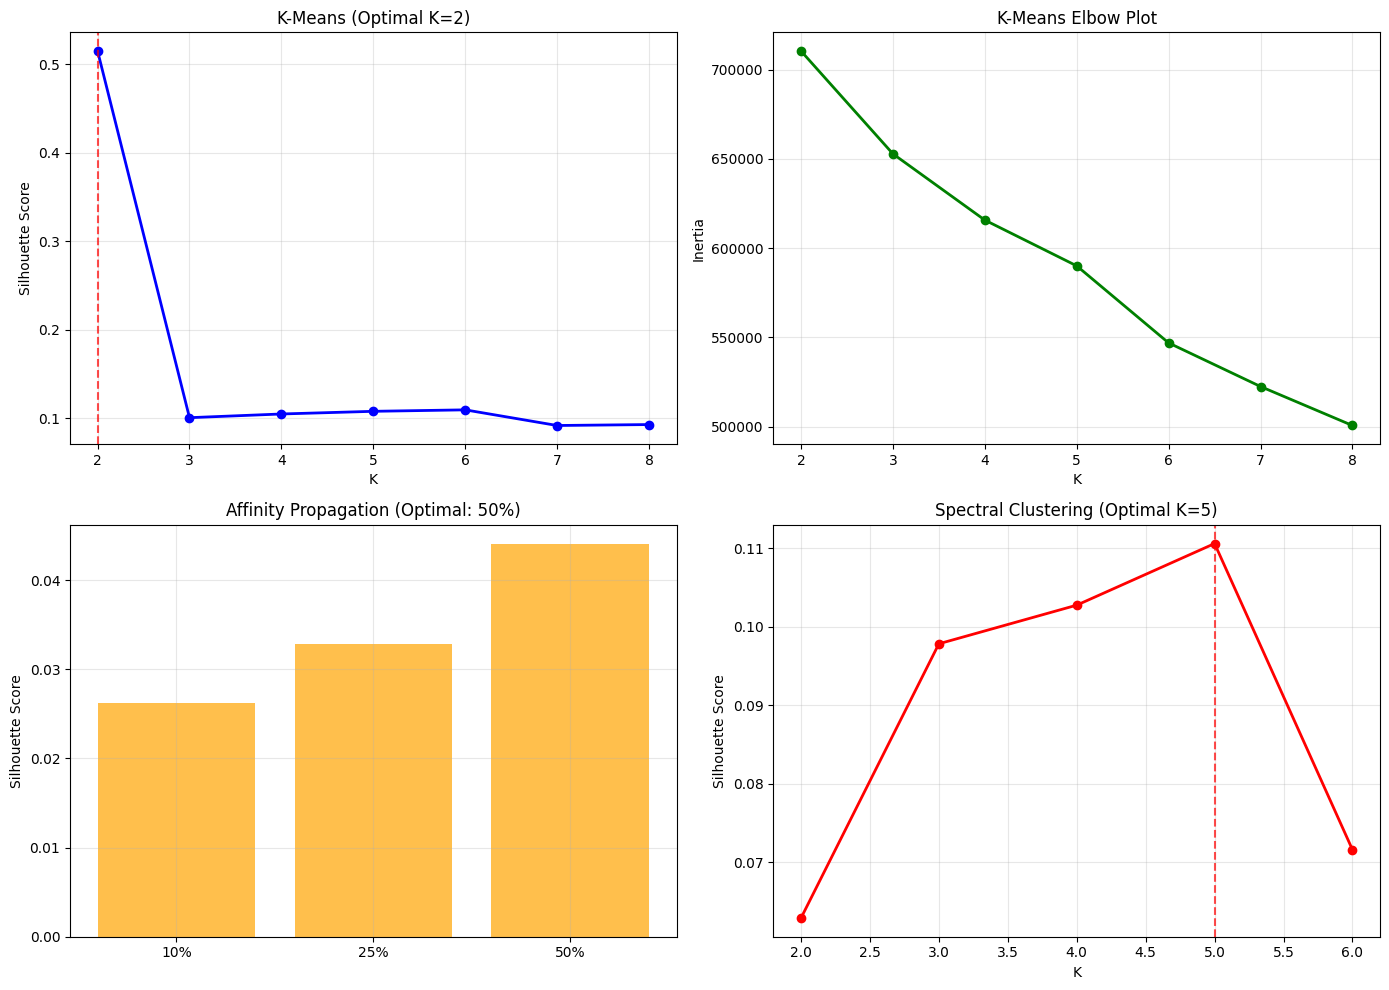

Creating PCA cluster visualizations...


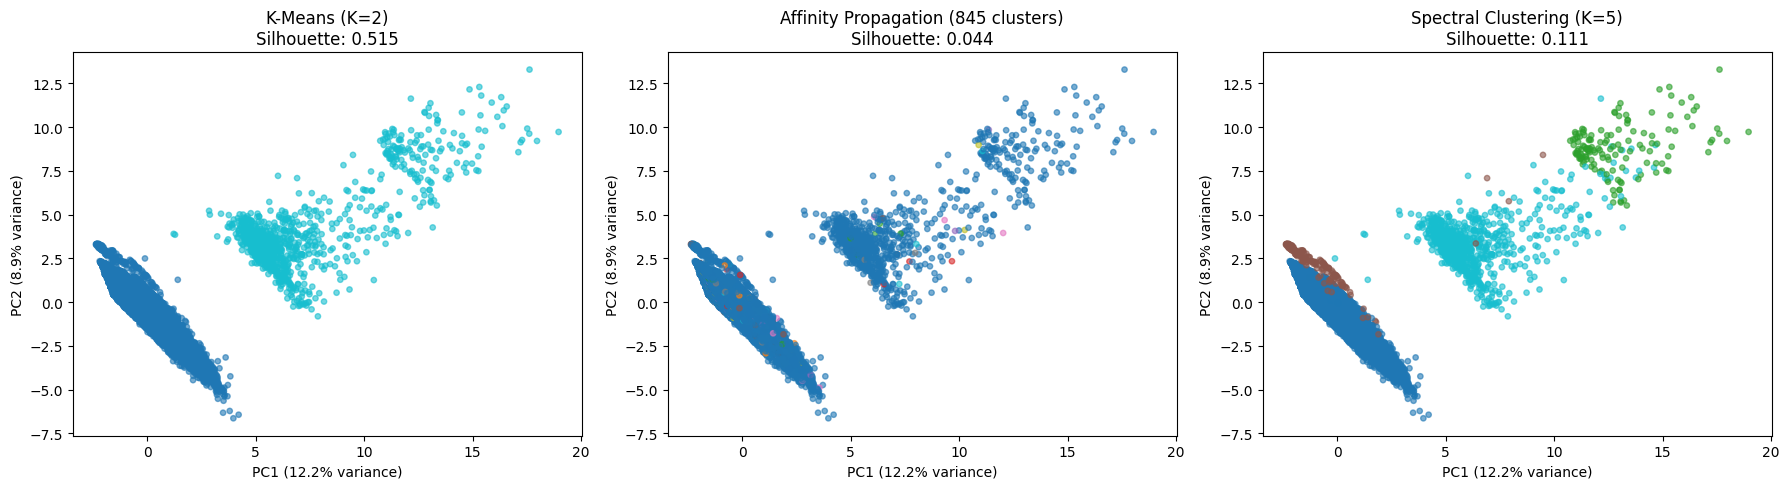


CLUSTER CHARACTERISTICS ANALYSIS
K-MEANS CLUSTER CHARACTERISTICS:
----------------------------------------

Cluster 0 (n=30445, 96.8%):
  Top categorical features:
    animal_type: CAT (47.5%)
    primary_color: BLACK (24.8%)
    secondary_color: None (52.9%)
    sex: Male (40.8%)
  Numerical characteristics:
    age_at_intake_days: 718.25 (overall: 741.79)
    visit_count: 1.00 (overall: 1.04)
    latitude: 33.81 (overall: 33.82)
    longitude: -118.16 (overall: -118.15)

Cluster 1 (n=996, 3.2%):
  Top categorical features:
    animal_type: DOG (66.1%)
    primary_color: BLACK (28.0%)
    secondary_color: None (43.6%)
    sex: Male (58.4%)
  Numerical characteristics:
    age_at_intake_days: 1461.16 (overall: 741.79)
    visit_count: 2.19 (overall: 1.04)
    latitude: 33.83 (overall: 33.82)
    longitude: -117.98 (overall: -118.15)

ALGORITHM PERFORMANCE SUMMARY
           Algorithm Parameters Silhouette_Score  N_Clusters
             K-Means        K=2           0.5150           2
A

In [92]:
# 1. Silhouette Score Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# K-Means silhouette scores
axes[0, 0].plot(k_range, kmeans_silhouette_scores, 'bo-', linewidth=2, markersize=6)
axes[0, 0].axvline(x=optimal_k_kmeans, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_xlabel('K')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title(f'K-Means (Optimal K={optimal_k_kmeans})')
axes[0, 0].grid(True, alpha=0.3)

# K-Means elbow plot
axes[0, 1].plot(k_range, kmeans_inertias, 'go-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('K')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].set_title('K-Means Elbow Plot')
axes[0, 1].grid(True, alpha=0.3)

# Affinity Propagation results
if ap_success:
    axes[1, 0].bar(range(len(preference_percentiles)), ap_silhouette_scores, color='orange', alpha=0.7)
    axes[1, 0].set_xticks(range(len(preference_percentiles)))
    axes[1, 0].set_xticklabels([f'{p}%' for p in preference_percentiles])
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title(f'Affinity Propagation (Optimal: {optimal_pref}%)')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Affinity Propagation\nFailed', ha='center', va='center', 
                   transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Affinity Propagation (Failed)')

# Spectral Clustering silhouette scores
if spectral_success:
    axes[1, 1].plot(spectral_k_range, spectral_silhouette_scores, 'ro-', linewidth=2, markersize=6)
    axes[1, 1].axvline(x=optimal_k_spectral, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_title(f'Spectral Clustering (Optimal K={optimal_k_spectral})')
else:
    axes[1, 1].text(0.5, 0.5, 'Spectral Clustering\nFailed', ha='center', va='center', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Spectral Clustering (Failed)')

axes[1, 1].set_xlabel('K')
axes[1, 1].set_ylabel('Silhouette Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. PCA Visualization of Clusters
print("Creating PCA cluster visualizations...")

# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca_2d = pca.fit_transform(X_processed)

# Create cluster comparison plot
n_plots = sum([1, ap_success, spectral_success])  # Count successful algorithms
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 1:
    axes = [axes]

plot_idx = 0

# K-Means visualization
scatter1 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                 c=best_kmeans_labels, cmap='tab10', alpha=0.6, s=15)
axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[plot_idx].set_title(f'K-Means (K={optimal_k_kmeans})\nSilhouette: {max(kmeans_silhouette_scores):.3f}')
plot_idx += 1

# Affinity Propagation visualization
if ap_success:
    # Map AP labels to full dataset
    if len(X_processed) > len(best_ap_labels):
        ap_labels_full = np.full(len(X_processed), -1)
        ap_labels_full[ap_indices] = best_ap_labels
    else:
        ap_labels_full = best_ap_labels
    
    scatter2 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                     c=ap_labels_full, cmap='tab10', alpha=0.6, s=15)
    axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[plot_idx].set_title(f'Affinity Propagation ({ap_n_clusters[optimal_pref_idx]} clusters)\nSilhouette: {max(ap_silhouette_scores):.3f}')
    plot_idx += 1

# Spectral Clustering visualization
if spectral_success:
    scatter3 = axes[plot_idx].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                                     c=best_spectral_labels, cmap='tab10', alpha=0.6, s=15)
    axes[plot_idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[plot_idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[plot_idx].set_title(f'Spectral Clustering (K={optimal_k_spectral})\nSilhouette: {max(spectral_silhouette_scores):.3f}')

plt.tight_layout()
plt.show()

# =============================================================================
# CLUSTER ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("CLUSTER CHARACTERISTICS ANALYSIS")
print("="*60)

# Analyze K-Means clusters (best performer likely)
df_analysis = df_cluster.copy()
df_analysis['KMeans_Cluster'] = best_kmeans_labels

print("K-MEANS CLUSTER CHARACTERISTICS:")
print("-" * 40)

for cluster_id in sorted(df_analysis['KMeans_Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['KMeans_Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    percentage = (cluster_size / len(df_analysis)) * 100
    
    print(f"\nCluster {cluster_id} (n={cluster_size}, {percentage:.1f}%):")
    
    # Top categorical characteristics
    print("  Top categorical features:")
    for cat_col in categorical_cols[:4]:  # Show top 4 categorical features
        if cat_col in cluster_data.columns:
            top_category = cluster_data[cat_col].mode().iloc[0]
            cat_percentage = (cluster_data[cat_col] == top_category).mean() * 100
            print(f"    {cat_col}: {top_category} ({cat_percentage:.1f}%)")
    
    # Numerical characteristics
    print("  Numerical characteristics:")
    key_numerical = ['age_at_intake_days', 'visit_count', 'latitude', 'longitude']
    for num_col in key_numerical:
        if num_col in cluster_data.columns:
            mean_val = cluster_data[num_col].mean()
            overall_mean = df_analysis[num_col].mean()
            print(f"    {num_col}: {mean_val:.2f} (overall: {overall_mean:.2f})")

# =============================================================================
# PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "="*60)
print("ALGORITHM PERFORMANCE SUMMARY")
print("="*60)

results = []
results.append(['K-Means', f'K={optimal_k_kmeans}', f'{max(kmeans_silhouette_scores):.4f}', optimal_k_kmeans])

if ap_success:
    results.append(['Affinity Propagation', f'Pref={optimal_pref}%', f'{max(ap_silhouette_scores):.4f}', ap_n_clusters[optimal_pref_idx]])

if spectral_success:
    results.append(['Spectral Clustering', f'K={optimal_k_spectral}', f'{max(spectral_silhouette_scores):.4f}', optimal_k_spectral])

summary_df = pd.DataFrame(results, columns=['Algorithm', 'Parameters', 'Silhouette_Score', 'N_Clusters'])
print(summary_df.to_string(index=False))

# Find best performing algorithm
best_score = summary_df['Silhouette_Score'].astype(float).max()
best_algorithm = summary_df.loc[summary_df['Silhouette_Score'].astype(float).idxmax(), 'Algorithm']

print(f"\nBest performing algorithm: {best_algorithm}")
print(f"Best silhouette score: {best_score:.4f}")

print(f"\nClustering analysis completed!")
print("Optimizations applied:")
print(f"- Dataset sampled to {len(df_cluster)} rows")
print(f"- Affinity Propagation limited to {AP_SAMPLE_SIZE} samples")
print(f"- Feature engineering with {X_processed.shape[1]} final features")
print("- Efficient algorithm parameters for speed")

In [89]:
_, cluster_labels_k2 = spectral_models[2]

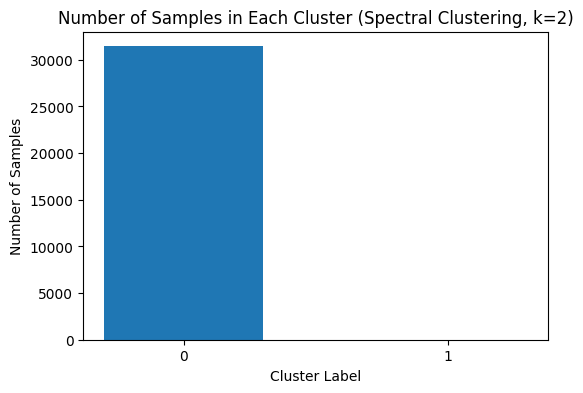

In [90]:
plt.figure(figsize=(6,4))
plt.hist(cluster_labels_k2, bins=np.arange(3)-0.5, rwidth=0.6)
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Cluster (Spectral Clustering, k=2)')
plt.xticks([0,1])
plt.show()

In [91]:
import numpy as np

# Extract cluster labels for k=3
_, cluster_labels_k3 = spectral_models[3]

# Get unique cluster labels and their counts
labels, counts = np.unique(cluster_labels_k3, return_counts=True)

# Print the counts for each cluster
for label, count in zip(labels, counts):
    print(f"Cluster {label}: {count} samples")

Cluster 0: 30250 samples
Cluster 1: 1179 samples
Cluster 2: 12 samples
